# Project Initialization

## Background


The goal for this project is to perform Time Series Forecasting on Air Pollution Dataset. We are given a training dataset to build your time series model, and to make prediction using the test dataset.

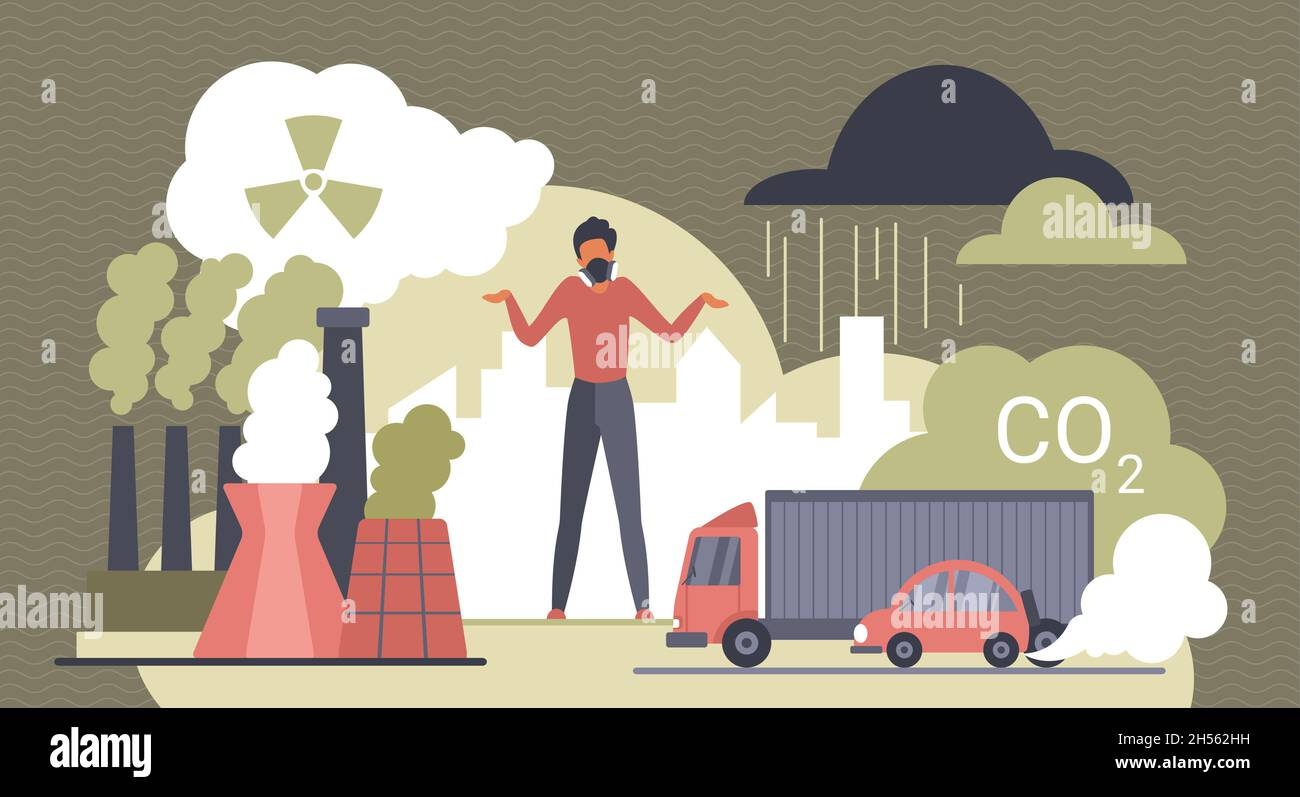

## Objective

> To forecast the Air Quality of Carbon Monoxide CO, Hydrocarbon(s) HC, Nitrous Dioxide NO2 and Ozone O3 for the next 63 Days(test size) using Univariate and Multivariate Statistical Model, given past Air Quality records and Temperature and RH of wanted forecasted days.

## Keywords


*   Time Series Forecasting
*   Seasonal Decomposition
*   Stationarity Testing
*   ACF + PACF
*   ARIMA
*   SARIMAX
*   VARMAX




## Dataset Background

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

The original dataset collected readings on a hourly basis. However, the data from dataset given is on a daily basis. After manually calculating certain rows,we can confirm that the daily readings are derived from averaging the 24hours of that particular day.

For now, we will keep this fact in mind and explore more on the implicaitons of missing values in the EDA process


## Load Dependencies

In [6]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# Utility
from tqdm import tqdm # Track progress of a loop
import warnings # Ignore warnings
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
from IPython.display import display, HTML, Markdown

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Load Train Dataset
Date formatting of the data does not follow the standard Pandas convention.
Therefore specift date formatting to convert date feature to Datetime

Time range for Train Dataset spans over 13 months from 03-2016 to 02-2017

In [8]:
df_raw = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
display(df_raw)

Date          T         RH Gas        Value  Unnamed: 5  Unnamed: 6
0    2016-03-15  12.020833  54.883334  CO  1053.200000         NaN         NaN
1    2016-03-16   9.833333  64.069791  CO   995.250000         NaN         NaN
2    2016-03-17  11.292708  51.107292  CO  1025.250000         NaN         NaN
3    2016-03-18  12.866319  51.530903  CO  1064.444444         NaN         NaN
4    2016-03-19  16.016667  48.843750  CO  1088.741667         NaN         NaN
...         ...        ...        ...  ..          ...         ...         ...
1307 2017-02-01   5.267708  39.614930  O3   553.180556         NaN         NaN
1308 2017-02-02 -55.515972 -24.010417  O3   343.500000         NaN         NaN
1309 2017-02-03 -14.272917  28.563542  O3   334.458333         NaN         NaN
1310 2017-02-04   4.848611  37.832986  O3   379.513889         NaN         NaN
1311 2017-02-05   7.273958  31.809375  O3   947.333333         NaN         NaN

[1312 rows x 7 columns]

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1312 non-null   datetime64[ns]
 1   T           1312 non-null   float64       
 2   RH          1312 non-null   float64       
 3   Gas         1312 non-null   object        
 4   Value       1312 non-null   float64       
 5   Unnamed: 5  0 non-null      float64       
 6   Unnamed: 6  0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 71.9+ KB


## Metadata

| Attribute | Description | Type |
|---|---|---|
| Date  | Date in y-m-d format | datetime |
| T | Temperature in degrees | Numerical-Continuous |
| RH   | Relative humidity % | Numerical-Continuous |
| Gas | Type of pollution gas | Discrete |
| Value | Amount of pollution | Numerical-Continuous |


# Exploratory Data Analysis

In our EDA for time series anaylsis on Air pollution dataset. We mainly focus on acomplishing the following: 

1. Visualize time series across variables
1. Outlier + Missing Value analysis
2. Time series Decomposition
3. Strength of Trend and Seasonality of Gas values
4. Stationary Tests

## What is the timespan for this dataset?

In [10]:
print(f'Start Date:{df_raw["Date"].min()}\nEnd Date: {df_raw["Date"].max()}')

Start Date:2016-03-15 00:00:00
End Date: 2017-02-05 00:00:00


Conclusion:
Time range for Train Dataset spans over 13 months from 03-2016 to 02-2017

## Pre-eda processing: Datetime Index

Since we are given a panel data, a time series with more than one relative variable in the same period.

We will be creating a datetime index 

In [11]:
df_raw.set_index('Date', inplace=True)
display(df_raw)

T         RH Gas        Value  Unnamed: 5  Unnamed: 6
Date                                                                     
2016-03-15  12.020833  54.883334  CO  1053.200000         NaN         NaN
2016-03-16   9.833333  64.069791  CO   995.250000         NaN         NaN
2016-03-17  11.292708  51.107292  CO  1025.250000         NaN         NaN
2016-03-18  12.866319  51.530903  CO  1064.444444         NaN         NaN
2016-03-19  16.016667  48.843750  CO  1088.741667         NaN         NaN
...               ...        ...  ..          ...         ...         ...
2017-02-01   5.267708  39.614930  O3   553.180556         NaN         NaN
2017-02-02 -55.515972 -24.010417  O3   343.500000         NaN         NaN
2017-02-03 -14.272917  28.563542  O3   334.458333         NaN         NaN
2017-02-04   4.848611  37.832986  O3   379.513889         NaN         NaN
2017-02-05   7.273958  31.809375  O3   947.333333         NaN         NaN

[1312 rows x 6 columns]

## Initial Time series Visualization

To give us a visual representation of our time series data

In [12]:
# plot time series data
features = ["T",	"RH",	"Value"]
fig = make_subplots(rows=3, cols=1)

for i, feature in enumerate(features):
    fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw[feature], name=feature), row=i+1, col=1)
    # add name to subplots
    fig.update_yaxes(title_text=feature, row=i+1, col=1)
fig.update_layout(height=800, width=1200, title_text="Time Series analysis of Temperature, Relative Humidity and Value")
fig.show()

Observations: 


*   There is a consistent reoccurence in extreme negative values across T , RH and Value series. I.e When any features T, RH or Values spikes towards a negative values at a particular point in time all feautues will spike down at the datetime index
*   Value Series looks too clustered, with high variance in quantity.


Actions

* Further Analyse Drifting for extreme negative Values 
* check on Value and it's relationship with other variables
* Pivot Table on Value column

## Data Processing: Pivoting Table
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row turning every gas into its individual column. 

In [13]:
df_raw_pivot = pd.pivot(df_raw, values="Value", columns="Gas")
df_raw_pivot[["T", "RH"]] = df_raw[["T", "RH"]].groupby(df_raw.index).mean()

df_raw_pivot.head()

Gas                  CO          HC          NO2          O3          T  \
Date                                                                      
2016-03-15  1053.200000  729.800000   933.800000  876.833333  12.020833   
2016-03-16   995.250000  681.441667  1021.750000  708.025000   9.833333   
2016-03-17  1025.250000  806.583333   881.375000  867.375000  11.292708   
2016-03-18  1064.444444  794.258333   794.527778  996.625000  12.866319   
2016-03-19  1088.741667  755.083333   800.883333  987.341667  16.016667   

Gas                RH  
Date                   
2016-03-15  54.883334  
2016-03-16  64.069791  
2016-03-17  51.107292  
2016-03-18  51.530903  
2016-03-19  48.843750

## What's the frequency of time series data 

Is our dataset recorded every day?,every two days?,every week? or every month?

In [14]:
df_raw_pivot.index

DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22',
               '2016-03-23', '2016-03-24',
               ...
               '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

From the looks of sameple index, it seems to be daily. We still will need to verify this


In [15]:
len(df_raw_pivot) - len(df_raw_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency

In [16]:
df_raw_pivot = df_raw_pivot.asfreq("D") # explicitly state a daily frequency

## Missing Values Analysis

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

Let's take a deeper analysis to check the implications when -200 on the Values of Gases

In [17]:
display(df_raw_pivot[df_raw_pivot['T'] == -200])

Gas            CO     HC    NO2     O3      T     RH
Date                                                
2016-06-25 -160.0 -160.0 -160.0 -160.0 -200.0 -200.0
2016-09-01 -160.0 -160.0 -160.0 -160.0 -200.0 -200.0
2016-12-20 -160.0 -160.0 -160.0 -160.0 -200.0 -200.0
2016-12-21 -160.0 -160.0 -160.0 -160.0 -200.0 -200.0
2017-01-08 -160.0 -160.0 -160.0 -160.0 -200.0 -200.0
2017-01-09 -160.0 -160.0 -160.0 -160.0 -200.0 -200.0

Observations:

When Temperature `T` or `RH` have Values of -200, all the other gases will have values of -160

Conclusion:

Further Explore on these -200 and -160 values

In [18]:
def plot_ts(df,title):
    '''
    Funtion takes in a dataframe and plots the time series for all columns in the dataframe
    '''
    fig = make_subplots(rows= len(df.columns), cols=1, subplot_titles=df.columns)
    for i, feature in enumerate(df.columns):
        fig.add_trace(go.Scatter(x=df.index, y=df[feature], name=feature), row=i+1, col=1)
        # add name to subplots
        fig.update_yaxes(title_text=feature, row=i+1, col=1)
        fig.update_layout(height=800, width=1200, title_text=title)
    return fig

In [19]:
all_gases_ts = plot_ts(df_raw_pivot,title= "Time Series analysis of all gases seperately")
all_gases_ts.show()

**Observations**

*   There's interesting trend that when either one of the gasses are tagged with -160 value, the rest of the gasses will be -160 as well
*   The extreme values seems to appear randomly with no pattern

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

**Action**

*    Interpolate the missing value using instead of dropping it.


## Data Processing: Interpolation on *"Missing"* values

In [20]:

# Replace Gases Values -160 and Temperature/RH values -200 with Null
df_pivot_impute = df_raw_pivot[['CO','HC','NO2','O3','T','RH']].replace({-160: np.NaN,-200: np.NaN}) # Replace Gases Values -160 and Temperature/RH values -200 with Null
print("\nNumber of Missing Rows after Replace with NULL : \n{}".format(df_pivot_impute.isnull().sum()))


# Interpolate missing values
df_pivot_impute = df_pivot_impute.interpolate(method='linear', limit_direction='forward', axis=0)
print("\nNumber of Missing Rows after interpolation: \n{}".format(df_pivot_impute.isnull().sum()))



Number of Missing Rows after Replace with NULL : 
Gas
CO     6
HC     6
NO2    6
O3     6
T      6
RH     6
dtype: int64

Number of Missing Rows after interpolation: 
Gas
CO     0
HC     0
NO2    0
O3     0
T      0
RH     0
dtype: int64


In [21]:
# Re-plot Time Series after interpolation
all_gases_after_interpolation = plot_ts(df_pivot_impute,title= "Time Series analysis of all gases seperately after interpolation")
all_gases_after_interpolation.show()

Observation:

There is still occurance of extreme values seems to appear randomly with no pattern. E.g `RH` on Apr 14 2016 with `RH` of -188 which doesn't make sense as Relative Humidity is calculated as a percentag. Percentages cannot be negative 

Conclusion:

Further Explore on these drifted extreme value

## Extreme Values analysis

After imputing the missing values -200 and -160 as NaN.

The minumum values for Temperature is still -191 degrees, which is ilogical for climate in Italy ( which the dataset was taken from )

Furthermore Relative Humidity percentage metric, thus even more ilogical for percentage to be negative



---
After digging around the orginal dataset FROM UCI repository, and comparing it with the given dataset, I found out that when the school merged the hourly readings from the original dataset, they merged days that certain contains both missing and actual readings per hour

As a result if just 1hour out of the 24 hours in a day had actual readings the averaged value will be slightly lower than -200 OR < -160 for gases

We will call these extreme values drifted missing values

In [22]:
df_pivot_impute.min()

Gas
CO    -114.133333
HC    -122.766667
NO2   -124.466667
O3    -114.958333
T     -191.164583
RH    -188.839583
dtype: float64

### Imputing drifted missing values

From background research of origns of data collection to be Italy. The lowest recorded temperature in Italy is found to be **-49.6 °C** 

Therefore, We will use a threshold value of `T` < -49 OR `RH` < 0 ( AKA negative percentage for RH which makes no sense ) to extract all partically affected missing value ( as explained above )

In [23]:
# Create Boolean Column to Indicate Drifting when Temperature is less than -49 OR RH < 0 (Abnormal)

df_pivot_impute['Drift'] = (df_pivot_impute['T'] < -49) | (df_pivot_impute['RH'] < 0)

# Extract drift rows
df_pivot_impute[df_pivot_impute['Drift'] == True]

Gas                 CO          HC         NO2          O3           T  \
Date                                                                     
2016-04-14 -114.133333 -122.766667 -124.466667 -114.958333 -191.164583   
2016-05-30  598.225000  569.850000  623.550000  557.075000  -23.920833   
2016-05-31  489.027778  530.961111  480.750000  514.877778  -57.951736   
2016-06-24  385.402778  326.963889  362.972222  305.705556  -68.069792   
2016-06-25  496.197222  478.977778  461.769444  412.823611  -40.109375   
2016-06-26  606.991667  630.991667  560.566667  519.941667  -12.148958   
2016-08-31   48.866667   14.841667   82.016667   -0.975000 -144.072917   
2016-09-01  345.833333  285.170833  324.454167  246.183333  -72.343229   
2016-09-13  180.166667  182.550000   92.991667  228.008333 -133.732292   
2016-12-19  648.391667  588.127778  333.647222  794.986111  -51.363194   
2016-12-20  441.936111  392.029630  207.981481  536.268519  -89.078935   
2016-12-21  235.480556  195.931481   82.315741  277.550926 -126.794676   
2016-12-22   29.025000   -0.166667  -43.350000   18.833333 -164.510417   
2017-02-02  474.291667  347.480556  508.180556  343.500000  -55.515972   

Gas                 RH  Drift  
Date                           
2016-04-14 -188.839583   True  
2016-05-30  -24.786458   True  
2016-05-31  -61.500694   True  
2016-06-24  -58.296875   True  
2016-06-25  -31.856771   True  
2016-06-26   -5.416667   True  
2016-08-31 -138.672917   True  
2016-09-01  -64.682812   True  
2016-09-13 -133.684375   True  
2016-12-19  -11.956250   True  
2016-12-20  -59.476042   True  
2016-12-21 -106.995833   True  
2016-12-22 -154.515625   True  
2017-02-02  -24.010417   True

### Visualizing Drifted values

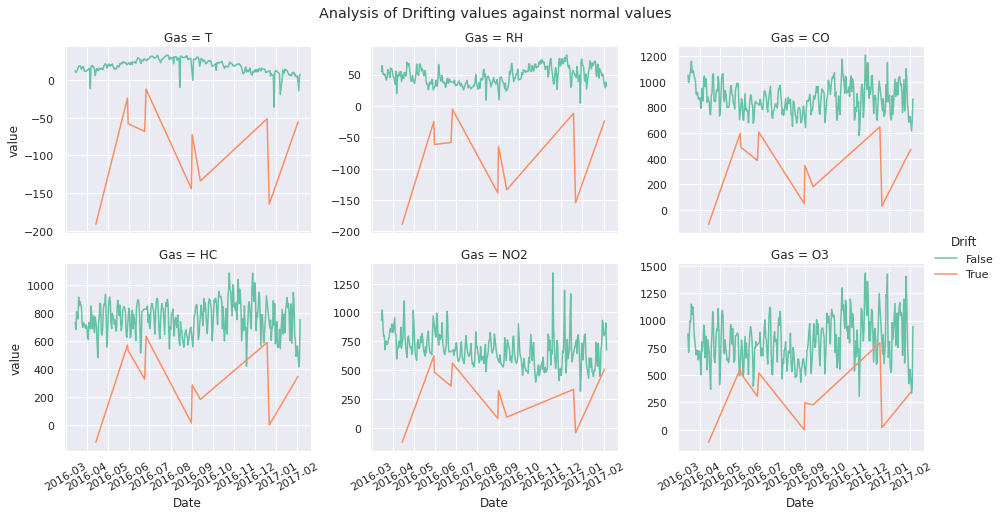

In [24]:
g = sns.FacetGrid(
        pd.melt(
            df_pivot_impute, 
            id_vars='Drift', 
            value_vars=['T', 'RH', 'CO','HC','NO2','O3'], 
            ignore_index=False).reset_index(), 
        col="Gas", 
        hue = 'Drift',
        palette="Set2",
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
#add legend
g.add_legend()
g.fig.subplots_adjust(top=0.9) # adjust the Figure in g
g.fig.suptitle('Analysis of Drifting values against normal values')

plt.show()

Observations: 
* Using only `T` and `RH` as the indicator to a drifting, we can see similar drifted values from all other `gas` values. Indicating, when either temperature or RH sensors is faluty, the sensors all the gases become faluty as well
* It seems like drifting values appear randomly following no repeated pattern

**Action**

Interpolate all values for drifted data

## Data Processing: Interpolatation on *"Drifted"* values

In [25]:
# Replace Drifting Values with Null
df_pivot_impute.loc[df_pivot_impute['Drift']] = np.nan
print("\nNumber of Missing Rows after drifted values Replace with NULL : \n{}".format(df_pivot_impute.isnull().sum()))

df_pivot_impute = df_pivot_impute.interpolate(method='linear', limit_direction='forward', axis=0)
print("\nNumber of Missing Rows after interpolated drifted values: \n{}".format(df_pivot_impute.isnull().sum()))
df_pivot_impute.drop(columns= 'Drift', inplace = True) # remove Drift column



Number of Missing Rows after drifted values Replace with NULL : 
Gas
CO       14
HC       14
NO2      14
O3       14
T        14
RH       14
Drift    14
dtype: int64

Number of Missing Rows after interpolated drifted values: 
Gas
CO        0
HC        0
NO2       0
O3        0
T         0
RH        0
Drift    14
dtype: int64


In [26]:
final_ts = plot_ts(df_pivot_impute,title= "Time Series analysis of all gases seperately after interpolation and drift removal")
final_ts.show()


Observations:

Succesfully removed extreme outliers and time series looks much cleaner

# Time series Decomposition

Time series data usually exhibit different kinds of patterns, which can be broken down into components of Time Series to understand our data better.

* Trend component: 
  > Trend shows whether the data tends to increase or decrease on a average, long-term, smooth tendency.
* Seasonality component: 
  > Variation in varible due to some predetermined patterns over the same period of time

* Cyclical component:
  > In which there is no fixed interval, uncertainty in movement and its pattern

* Irregularity: 
  > Unexpected situations/events/scenarios and spikes in a short time span.

There are two ways which we can decompose our data.

**Additively** ($y_t = S_t + T_t + R_t$), or **multiplicatively** ($y_t = S_t \times T_t \times R_t$).

From our initial TS plot, we can see that variance does not change as the mean changes. Therefore, we will choose to use an **additive model** for decomposition

---

Seasonal Decomposition
Column: CO
Seasonal 7


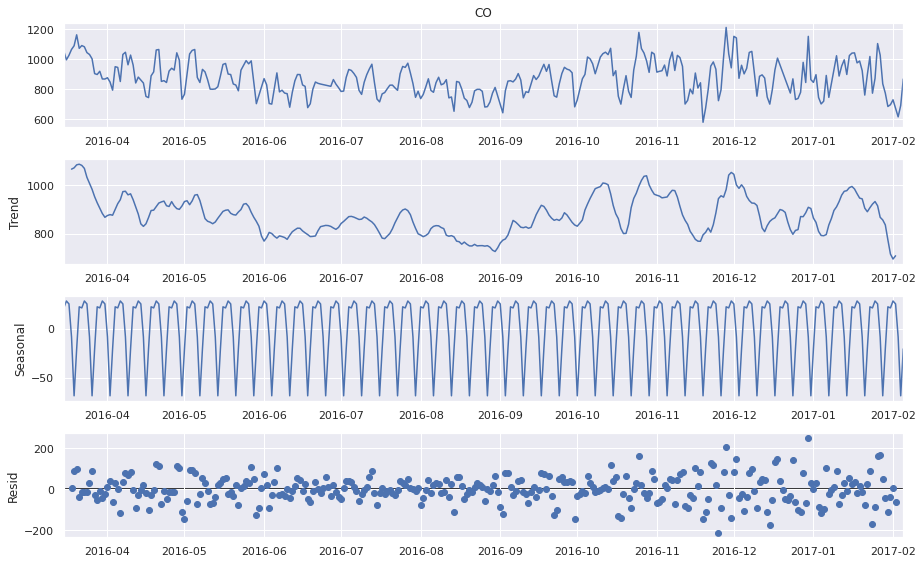

---

Seasonal Decomposition
Column: HC
Seasonal 7


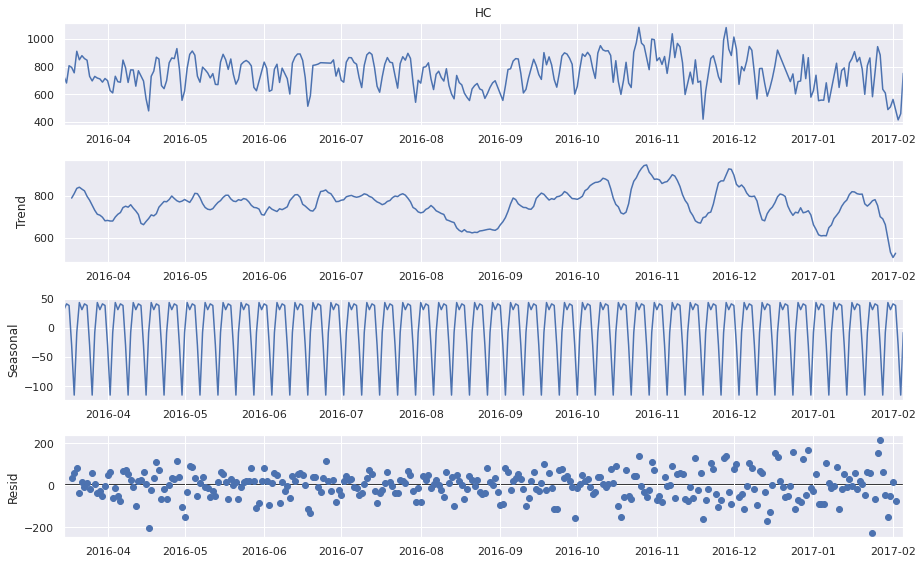

---

Seasonal Decomposition
Column: NO2
Seasonal 7


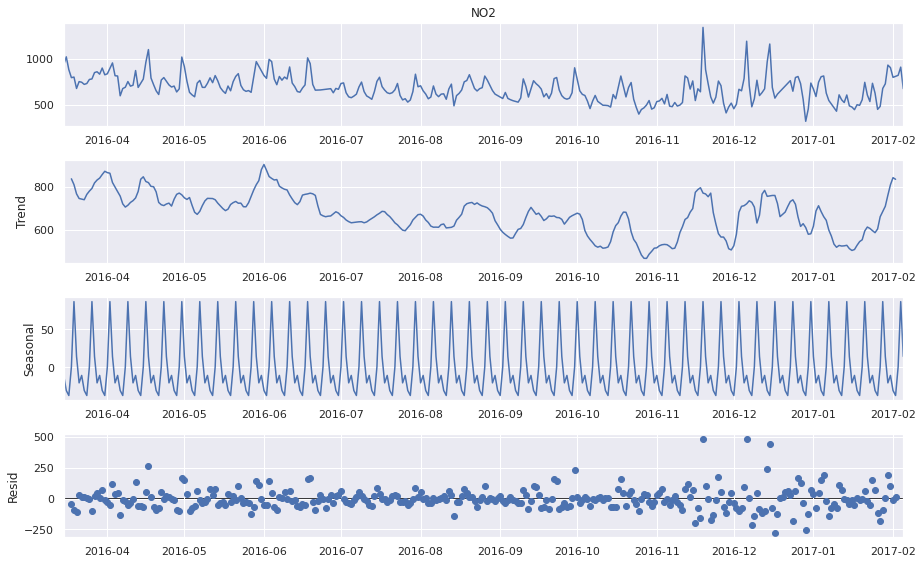

---

Seasonal Decomposition
Column: O3
Seasonal 7


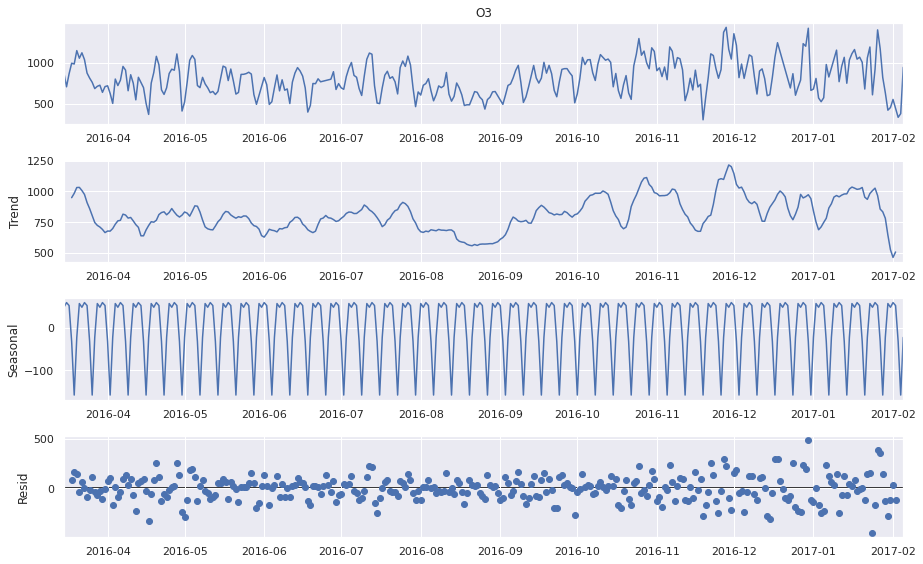

---

Seasonal Decomposition
Column: T
Seasonal 7


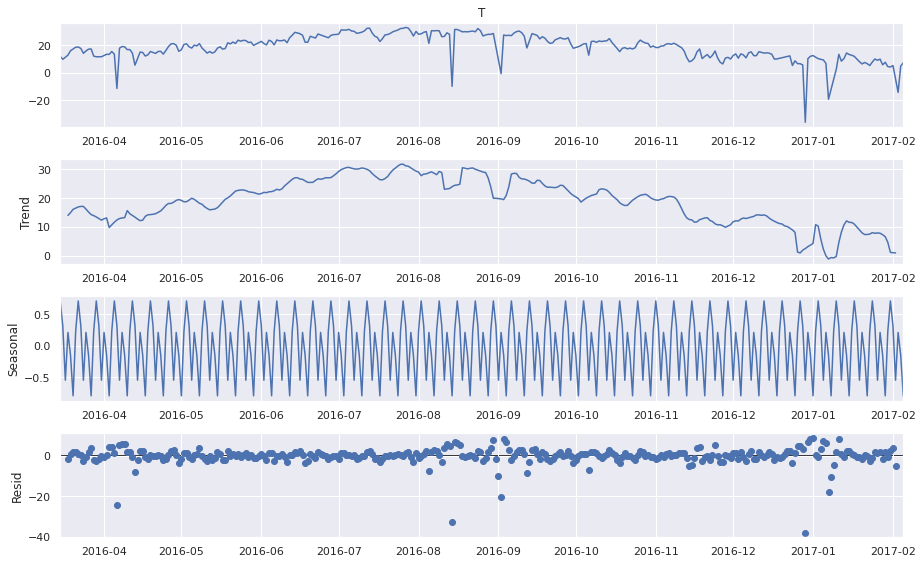

---

Seasonal Decomposition
Column: RH
Seasonal 7


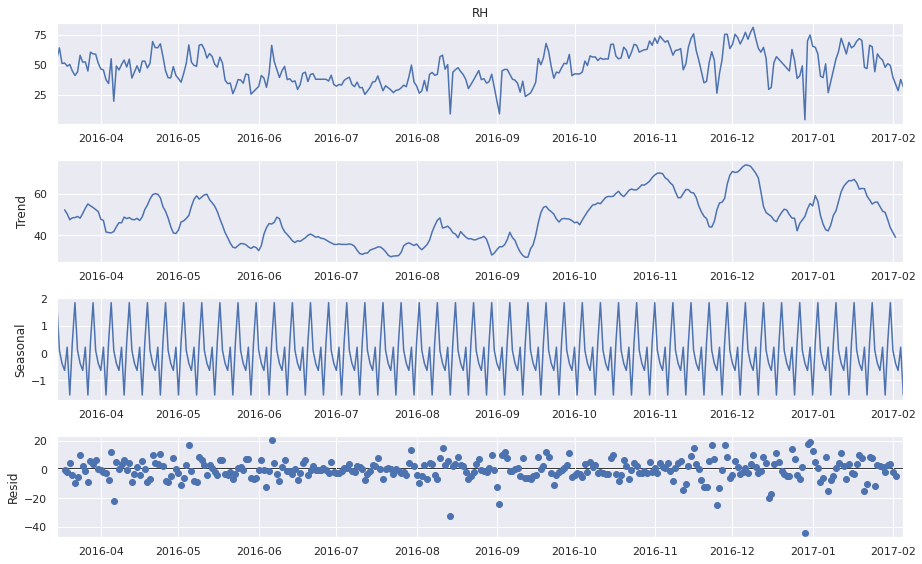

---

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal decomposition
display(Markdown('---'))
for i in df_pivot_impute.columns:
    print('Seasonal Decomposition\nColumn:', i)
    decomposition = seasonal_decompose(df_pivot_impute[i])
    print('Seasonal', len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()
    display(Markdown('---'))

Observation:

* For all variables, there is no linear trend in the data
* Strong seasonality for all *Gas* variables and even T and RH. with there being a cycle that seemingly corresponds to 7 days AKA weekly
 

Conclustion:

* Models that account for seasonality like SARIMA/SARIMAX might perform well on our data

# Stationary test

Knowing if our data is stationary is neccessary as having Stationary data one of the statistical assumptions that may be made by our models any (AR MA models)

Stationary data represents  **mean, variance and covariance does not vary with time.**

There are two statistical test we can perform to check for stationary data


*   Augmented Dickey-Fuller Test ( ADF )
*   Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

We will choose to apply/run both the tests and makes sure that the series is truly stationary


## ADF test for stationary

To verify stationarity, we will be utilising Augmented Dickey Test at Significant Value, $p=0.05$ with,
$$
H_0 : \text{Time-Series is Non-Stationary,there is a unit root} \\
H_1 : \text{Time-Series is Stationary, there is no unit root} 
$$

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [28]:
significance_level = 0.05
for feature in df_pivot_impute.columns:
    print(f'\n{feature}')
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Time-Series is Non-Stationary,there is a unit root \nH1: Time-Series is Stationary,there is no unit root ")
    test_statistic, pvalue, usedlag, *_ = adfuller(df_pivot_impute[feature])
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    display(test_statistic, pvalue, usedlag)


CO
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.


-4.575823082925207

0.000143092766405663

8


HC
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.014
Used Lag: 14
Reject H0. There is evidence that the time series is stationary.


-3.3195418872757965

0.01402723165653481

14


NO2
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.001
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.


-4.025192241515699

0.0012841927276947844

6


O3
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.017
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.


-3.2615893690510593

0.01668520132259048

12


T
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.865
Used Lag: 10
Fail to reject H0. There is insufficient evidence that the time series is stationary.


-0.6245807540372387

0.8653304937565434

10


RH
Test for Stationarity
Significance Level: 0.05
H0: Time-Series is Non-Stationary,there is a unit root 
H1: Time-Series is Stationary,there is no unit root 
P-value: 0.000
Used Lag: 2
Reject H0. There is evidence that the time series is stationary.


-4.842786849897104

4.5011866934473136e-05

2

ADF Observations:

*   All Gases `CO`,`HC`, `NO2` and `O3` time series are stationary at $p=0.05$ 
*   Only `T` temperature does not appear to be stationary 

## KPSS test for stationary

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) similar to ADF in that it also tests for the stationarity of time series.

#### How is KPSS test different from ADF test?

KPSS test has the capability to check for stationarity in the *presence of a deterministic trend*. Impliying the slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path.

$$
H_0 : \text{Time-Series is Non-Stationary,there is a unit root} \\
H_1 : \text{Time-Series is Stationary, there is no unit root} 
$$

[References: Machine Learning+ KPSS Test for Stationarity](https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/#:~:text=In%20python%2C%20the%20statsmodel%20package,the%20opposite%20to%20each%20other.)

In [29]:
def KPPS_test(df, significance_level = 0.05, columns = ['CO', 'HC', 'NO2', 'O3', 'T', 'RH'],diff=False):
  for feature in columns:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      if diff:
        print(f'\n{feature},difference=1')
      else:
        print(f'\n{feature}')
      print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary \nH1: There is a unit root (non-stationary)")
      if diff:
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature].diff().dropna(), regression="c", nlags="auto")
      else:
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature], regression="c", nlags="auto")
      print(f'KPSS Statistic: {test_statistic}')
      print(f"P-value: {pvalue:.3f}")
      print(f"Used Lag: {usedlag}")
      if pvalue < significance_level:
          print("Reject H0. There is evidence that the time series is not stationary.")
      else:
          print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
      display(test_statistic, pvalue, usedlag)

In [30]:
KPPS_test(df_pivot_impute)


CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.2693834204074792
P-value: 0.100
Used Lag: 9
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.2693834204074792

0.1

9


HC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.14994490675957448
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.14994490675957448

0.1

7


NO2
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 1.3944454038527225
P-value: 0.010
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


1.3944454038527225

0.01

8


O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.6928927562984605
P-value: 0.014
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


0.6928927562984605

0.014191567609230864

8


T
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 1.2240681920172252
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


1.2240681920172252

0.01

10


RH
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.8796570309740344
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


0.8796570309740344

0.01

10

KPSS Observations:

*   Only Gases `CO` and `HC` time series are **stationary** at $p=0.05$ 
*   Gases `NO2` and `O3` time series is **not stationary** at $p=0.05$ 
*   Both `T` and `RH` time series is **not stationary** at $p=0.05$ 

## Final Conclusiton for stationary test


1.   Time series for Gases `CO` and `HC`: Both tests conclude that the given series is stationary – These two series is stationary


> No differencing needed


2.  Time series for Gases `NO2` and `O3`: **ADF concludes stationary and KPSS concludes non-stationary** – These two series is difference stationary.

> Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

3. Time series for `T`: Both tests conclude that the given series is non-stationary – The series is non-stationary

4. Time series for `RH`: ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary.

[Reference: Statistical tests to check stationarity in Time Series](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=In%20python%2C%20the%20statsmodel%20package,the%20opposite%20to%20each%20other.)


In [31]:
# Re-run KPPS Test for NO2 and O3 when differenced by 1
KPPS_test(df_pivot_impute,columns=['NO2','O3'],diff=True)


NO2,difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.22753781203144954
P-value: 0.100
Used Lag: 86
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.22753781203144954

0.1

86


O3,difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary 
H1: There is a unit root (non-stationary)
KPSS Statistic: 0.08785184740065698
P-value: 0.100
Used Lag: 46
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.08785184740065698

0.1

46

Conclusion:

After differencing `NO2` and `O3` by period=1 

KPPS test concluded time series stationary

# Pre work for AR/MA: Autocorrelation Analysis 

## Auto-Correlation & Partial Auto-Correlation Plot (ACF, PACF)

We will be using ACF and PACF plots to helps detect patterns and check for randomness in our time series data.

Using the ACF plot we want to answer the following questions:

* Is the observed time series white noise/random?
* Is an observation related to an adjacent observation, an observation twice-removed, and so on?
* Can the observed time series be modeled with an MA model? If yes, what is the order?

PACF to answer:

* Can the observed time series be modeled with an AR model? If yes, what is the order?

[References](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)

ACF and PACF plots assumes stationary data, thus we will have to difference data for `NO2` and `O3` to make time series stationary before passing to ACF & PACF  

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



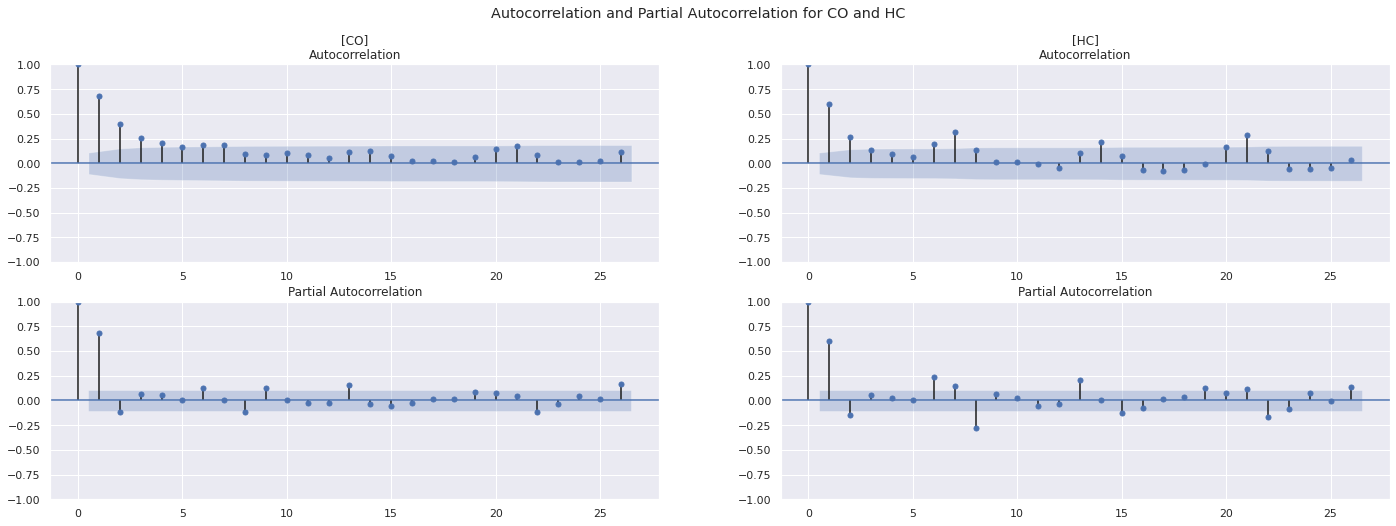

In [32]:
# Plot ACF for CO, HC
target_features = ['CO', 'HC']

fig, axes = plt.subplots(2,2, figsize = (24,8))
for idx, variable in enumerate(target_features):
    plot_acf(df_pivot_impute[variable],  ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_pivot_impute[variable], ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
# set main title
fig.suptitle("Autocorrelation and Partial Autocorrelation for CO and HC")
plt.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



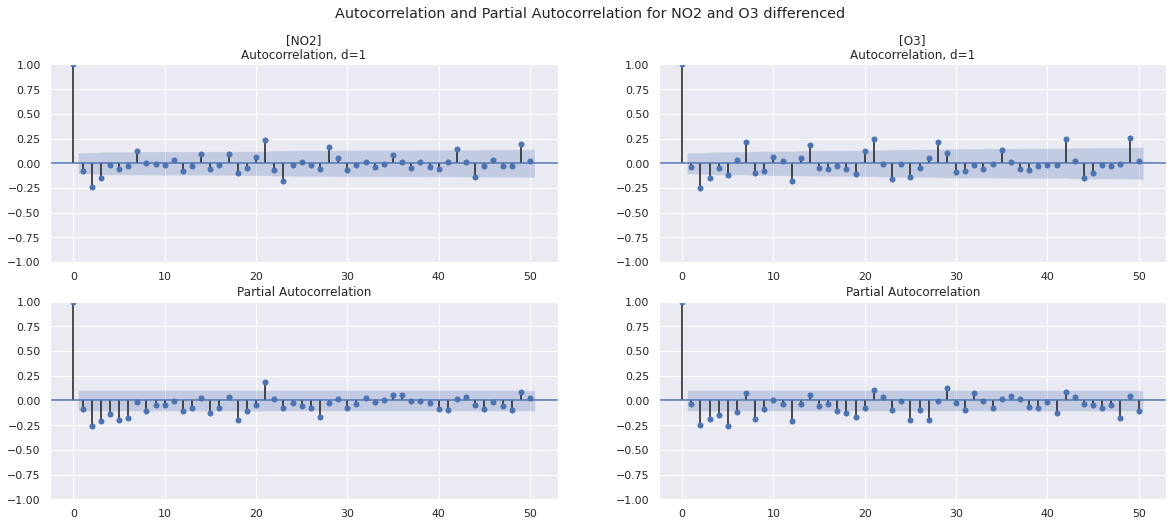

In [33]:
# Difference NO2 and O3 before plotting ACF and PACF
target_features = ['NO2', 'O3']

fig, axes = plt.subplots(2,2, figsize = (20,8))
for idx, variable in enumerate(target_features):
    plot_acf(df_pivot_impute[variable].diff().dropna(), lags = 50, ax = axes[0, idx]) # Difference in NO2 
    plot_pacf(df_pivot_impute[variable].diff().dropna(), lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation, d=1".format(variable))
# set main title
fig.suptitle("Autocorrelation and Partial Autocorrelation for NO2 and O3 differenced")
plt.show()

Observation:

For all gases `CO`,`HC`, `NO2` and `O3`:

*   There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

For `CO` and `HC`:
* Looking at PACF There is a significant lag spike at lag [0,1,2] for all the autocorrelation plot which makes p = [0,1,2] prime candidates
* Looking at ACF there are about 5 spikes above significant interval which makes q = [0,1,2,3,4,5] potential candidates

For `NO2` and `O3`:
* Looking at PACF There is significant lag spike only at [0] for all the autocorrelation plot which makes p = [0] 

**Observation Summary**

| Gasses | AR(p significant lags) | MA(q significant lags) | Seasonal Trend | Potential Initial Model |
| ---    | ---   | ---   | :---                                   | :---    |
| CO     | 2     | 3   | Weak Seasonal Trend every 7 Iteration| MA(3)/ AR(2)/ ARMA(2,3)/SARIMA(2,0,3)(1,0,1,7) |
| HC   | 2     | 3     | Seasonal Trend every 7 Iteration | MA(3)/ AR(2)/ ARMA(2,3)/ SARIMA(2,0,3)(2,0,1,7)
| NO2    | 0     | 1     | Weak Seasonal Trend every 13 iterations    | MA(1)/ AR(0)/ ARMA(0,1)/SARIMA(0,1,1)(2,1,1,13) |
| O3     | 0     | 1     | Seasonal Trend every 7 Iteration | MA(1)/ AR(0)/ ARMA(0,1)/SARIMA(0,1,1)(1,1,1,7)

# Model Selection

There are many models for time series. From our EDA process, I've decided to use 3 models

* ARIMA 
    > From Stationary tests, we found `NO2` and `O3` need to be differenced for the time series to be stationary. Hence we chose ARIMA instead or ARMA to act as our baseline
*  SARIMA
    > From Time Series Decompsition, we found strong Seasonality trend in all 4 gases. Hence we will attempt to use Seasonal Autoregressive Integrated Moving Average(SARIMA) as SARIMA takes into account the seasonality patterns in the time series
* VARMAX
    > From Causation check between variables using Granger’s Causality Test, we found that time series for both `T` and `RH` causes time series in `CO` and `HC` and `O3`.VARMAX procedure enables you to model the dynamic relationship both between the dependent variables and also between the dependent and independent variables.



## Evaulation method: Cross Validation - Expanding Window



To validate and make sure the model is evaluated general potential. One way to achieve this is to train
the data using the passage of time in different windows.

#### Choosing test set size:

Since our kaggle test data spans over 63 days, I'll use 63 days for the test size for Expanding Window

#### Recording down model performance

We will record down the test RMSE for all models to a History to compare results between model with different orders


In [72]:
def modelEvaluation(model,endog,gas,exog=None,tscv=TimeSeriesSplit(n_splits=3,test_size=63),test_size=63,target_features=[],curve=True,**kwargs):
  '''
  Function takes in a model, endog variable/exog variable(if any) CV using Expanding windows methodology and evaluates the model on each window 
  Returns a dataframe with the model evaluation metrics
  Returns model parameters to plot diognostic and summary information
  Returns a time series plot of the model evaluation metrics on the last window only
  '''
  results = defaultdict(list)
  for idx, (train_idx,test_idx) in enumerate(tscv.split(endog)): # Expanding Window 
    if exog is not None:
      # print('Exog gas found')
      train_exog = exog.iloc[train_idx]
      test_exog = exog.iloc[test_idx]
    else:
      train_exog =None
      test_exog = None

    train_fold = endog.iloc[train_idx]
    test_fold = endog.iloc[test_idx]

    if exog is not None:
      res = model(endog = train_fold, exog = exog.iloc[train_idx], **kwargs).fit()
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1],exog=train_exog)
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1],exog=test_exog)

    else:
      res = model(train_fold,**kwargs).fit()
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1])
      # train_predict = res.forecast(len(train_idx))
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])
      # test_predict = res.forecast(len(test_idx))
    # test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    rmse_train = mean_squared_error(train_fold, train_predict,squared=False) # Get train rmse for each split
    results['Train RMSE'].append(rmse_train)
    rmse_test = mean_squared_error(test_fold,test_predict,squared=False) # Get test rmse for each split
    results['Test RMSE'].append(rmse_test)
    results['Difference in RMSE'].append(rmse_train - rmse_test)
    results['AIC'].append(res.aic)

    if curve and idx == 2: # Only plot Time series for last fold 
      plt.figure(figsize=(12,8))
      plt.plot(train_fold,label='Train')
      plt.plot(test_fold,label='Test')
      plt.plot(train_predict,label='Train Predicted')
      plt.plot(test_predict,label='Test Predicted')
      plt.legend()
      plt.title(f'{model.__name__} Model gas = {gas}')
      plt.show()
  # results['Train RMSE'] = np.array(['Train RMSE']).mean()
  # display(results)
  return res , results


### Organise Results

In [35]:
Total_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Gas'])

def addHistory(model_name,cv_metrics,gas,past_history):
    '''
    Function to add specific model evaluation metrics with order to a history dataframe for easier comparism 
    '''
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        'Difference in RMSE' : np.mean(cv_metrics['Difference in RMSE']),
        # "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    return history

### Analysise results

In [36]:
def parse_results(results):
    cols = [pd.DataFrame(results[col]) for col in results.keys()]
    # display(cols)
    return pd.concat(cols, axis=1, keys=results.keys())

# ARIMA Model

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



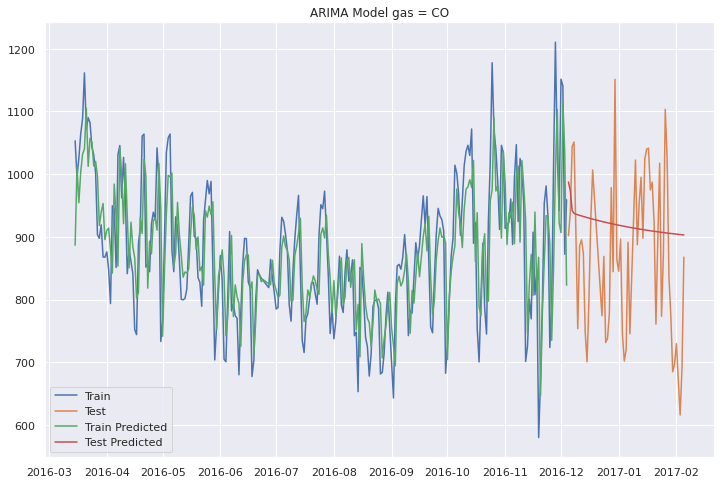

 25%|██▌       | 1/4 [00:02<00:06,  2.01s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



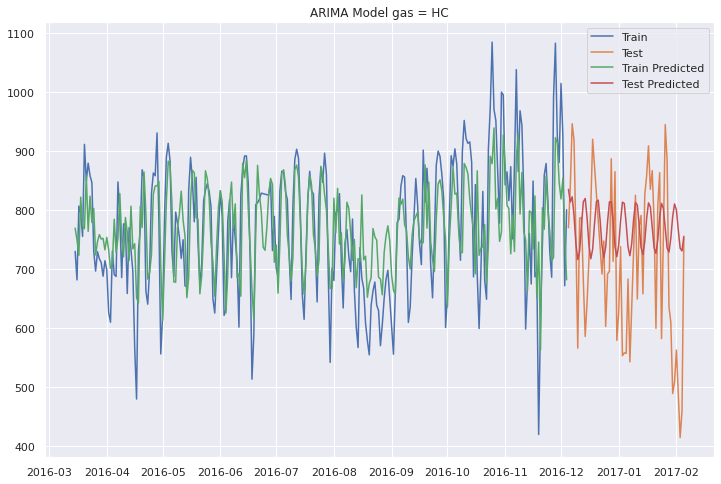

 50%|█████     | 2/4 [00:05<00:06,  3.15s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist

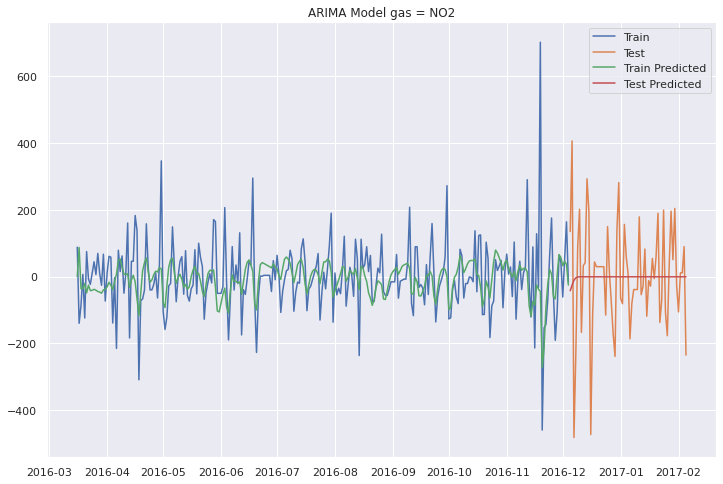

 75%|███████▌  | 3/4 [00:07<00:02,  2.44s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist

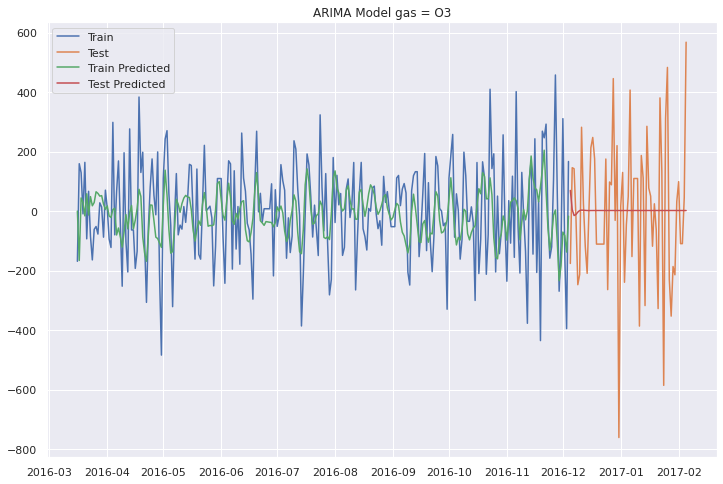

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


In [37]:
ARIMA_Results = defaultdict(list)
ARIMA_models = []

target_features = ['CO', 'HC', 'NO2', 'O3']
differenced_features = ['NO2', 'O3']

orders = {
    "CO" : (2,0,3),
    "HC" : (2,0,3),
    "NO2" : (2, 1, 2),
    "O3" : (2, 1, 2)
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(target_features):  
        order = orders[gas]
        if gas in differenced_features:
            # Difference before fitting
            model, eval_results = modelEvaluation(ARIMA, df_pivot_impute[gas].diff(periods=1).dropna(),gas=gas,target_features=target_features,curve= True ,order = order) 
        else:
            model, eval_results = modelEvaluation(ARIMA, df_pivot_impute[gas],gas=gas,curve= True,target_features=target_features, order = order)
        ARIMA_Results[gas] = eval_results
        ARIMA_models.append(model)

        Total_history = addHistory(f"ARIMA-{order}-{gas}", eval_results, gas, past_history=Total_history)
    # display(ARIMA_Results)

results = parse_results(ARIMA_Results)

By Plotting predictions on the last split of CV evaluation, we can see that ARIMA model generally doesn't generalize to test set well. For `CO`,`NO2`,`O3` Values the model predicts a straight line.

We will take a deeper look into the ARIMA model in the following section

### ARIMA Analysis

In [38]:
results.T

0            1            2
CO  Train RMSE            64.631206    63.784014    75.016225
    Test RMSE             94.796922   147.862010   129.067449
    Difference in RMSE   -30.165715   -84.077996   -54.051225
    AIC                 1564.040341  2262.041248  3052.526867
HC  Train RMSE            66.349994    68.535003    82.609693
    Test RMSE             96.587974   149.344699   141.592338
    Difference in RMSE   -30.237981   -80.809695   -58.982644
    AIC                 1574.689442  2295.907565  3107.143626
NO2 Train RMSE            95.626827    91.317460    95.535961
    Test RMSE             83.763873   142.371851   160.414828
    Difference in RMSE    11.862954   -51.054391   -64.878866
    AIC                 1647.203007  2381.568651  3155.325766
O3  Train RMSE           134.651676   127.261544   143.111610
    Test RMSE            119.085446   199.177199   244.371906
    Difference in RMSE    15.566230   -71.915655  -101.260296
    AIC                 1739.320323  2512.873347  3366.499204

Cross Validation Observations ARIMA:

* ARIMA Performance for`CO` is the best at 123 RMSE
* There is high difference between the Test RMSE across 3 test splits, the test RMSE difference (TrainRMSE-TestRMSE) for `O3` Ranges [31,-59,-90] across 3 splits   
* We can see that all models are slightly overfitting. Difference in RMSE between Train and Test is around -56 for CO and HC and -32 and -39 for NO2 and O3 respectively

                               SARIMAX Results                                
Dep. Variable:                     CO   No. Observations:                  265
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1519.263
Date:                Fri, 12 Aug 2022   AIC                           3052.527
Time:                        03:47:23   BIC                           3077.585
Sample:                    03-15-2016   HQIC                          3062.595
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        886.6470     42.668     20.780      0.000     803.019     970.275
ar.L1          1.0921      0.258      4.231      0.000       0.586       1.598
ar.L2         -0.1089      0.253     -0.431      0.6

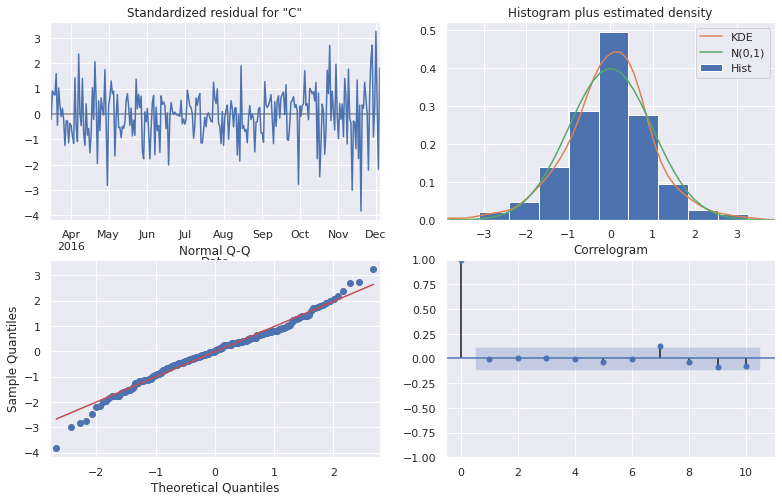

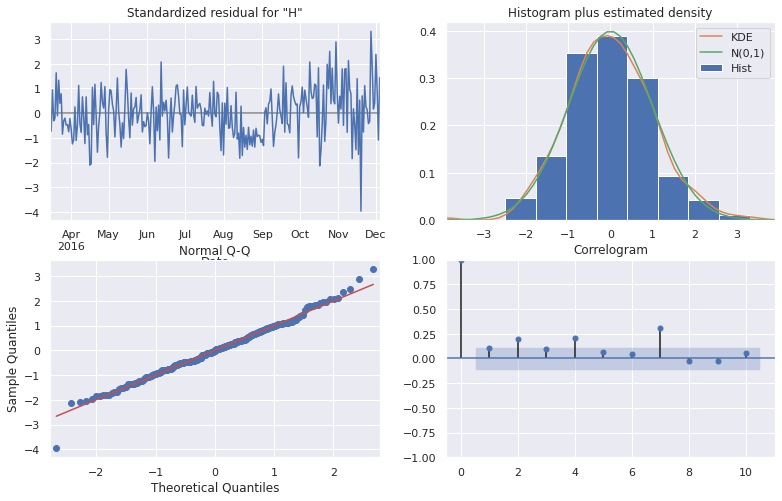

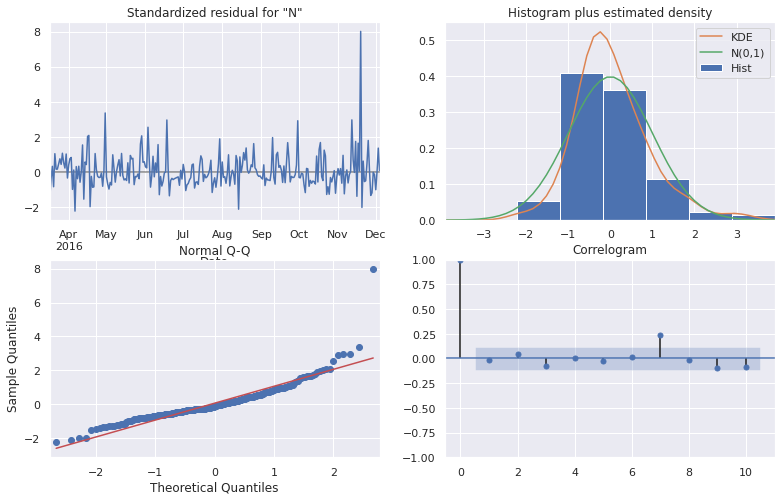

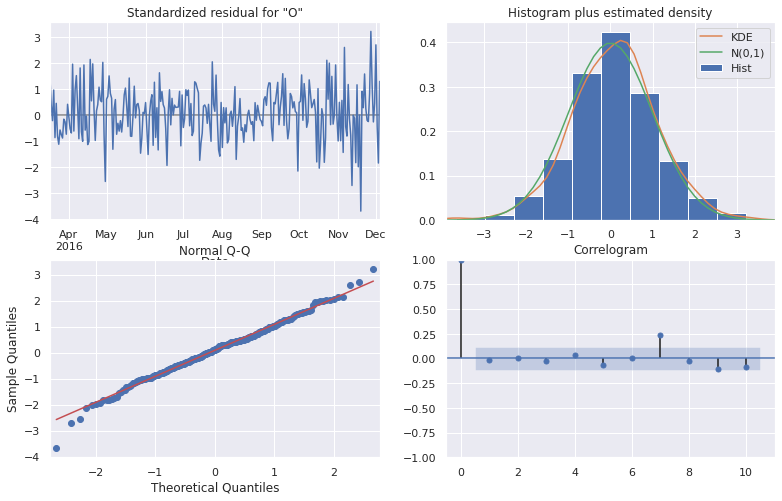

In [39]:
for model in ARIMA_models:
    print(model.summary())
    print(model.plot_diagnostics())

### Interpreting summary and digonstics for ARIMA

1. In the P>|z| column in Summary the coefficients are the P-values to hypothesis:

$$
H_0 : \text{Each coefficient is not statistically significant} \\
H_1 : \text{Each coefficient is statistically significant} 
$$

2. Ljung-Box (L1) (Q) is LBQ test statistic at lag 1, P-values to hypothesis:

$$
H_0 : \text{The errors are white noise} \\
H_1 : \text{The errors are not white noise} 
$$

3. Heteroskedasticity (H)  tests that the error residuals are homoscedastic or have the same variance. P-values to hypothesis:

$$
H_0 : \text{The residuals show variances} \\
H_1 : \text{The residuals show no variances} 
$$

4. Jarque-Bera (JB) tests for the normality of errors. P-values to hypothesis:

$$
H_0 : \text{ Data is normally distributed against an alternative of another distribution} \\
H_1 : \text{Data is not normally distributed against an alternative of another distribution} $$




#### **Individual Gases Observations ARIMA**
* CO
    * Only ar(2) and ma(1) is not statistically significant as its p-value is 0.668,0.317 which is > 0.05
    * The errors caused are not white noise
    * The residuals show no variances
    * Data not normally distributed against an alternative of another distribution
* HC
    * All coefficient is statiscally significant
    * The errors are white noise
    * The residuals show variances
    * Data is normally distributed against an alternative of another distribution
* NO2
    * ma(1) is not statistically significant as p-vale is 0.735 > 0.05
    * The errors are white noise
    * The residuals show variances
    *  Data is normally distributed against an alternative of another distribution
* O3
    * ar(1) is not statistically significant as p-value is 0.6 > 0.05
    * The errors are white noise
    * The residuals show variances
    *  Data is normally distributed against an alternative of another distribution

#### **General ARIMA model conclusion**

Presence of spike in correlogram value of 7. This is likely due to the fact that there is a seasonality of 7 in this Time Series.
Looking at the Q-Q plot, we can see that for all models, Residual values are extremely high for points at extreme ends, Model unable to predict extreme values well. The histogram for `CO` suggests that residuals are noramlly distributed for `CO`, but for `HC` and `NO2` and `O3` are positively skewed. 

Each model will need to be tuned further to find the optimal order 
    

In [40]:
# We will be using this history to compare the models moving forward
Total_history

Model Name  Mean Test RMSE  Difference in RMSE  Gas
0   ARIMA-(2, 0, 3)-CO      123.908794          -56.098312   CO
1   ARIMA-(2, 0, 3)-HC      129.175004          -56.676773   HC
2  ARIMA-(2, 1, 2)-NO2      128.850184          -34.690101  NO2
3   ARIMA-(2, 1, 2)-O3      187.544850          -52.536574   O3

## Testing Causation using Granger’s Causality Test

To determine whether or not one time series is useful for forecasting another ,can be used as an exogenous variable

This will help us in concluding if a Multivariate Modelling can be used for this time series.


$$
H_0 : \text{Time series x does not Granger-cause time series y} \\
H_1 : \text{Time series x Granger-causes time series y} 
$$

[Reference:](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)

In [41]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

g_test = grangers_causation_matrix(df_pivot_impute, variables = df_pivot_impute.columns)     

CO_x    HC_x   NO2_x    O3_x     T_x    RH_x
CO_y   1.0000  0.0001  0.0035  0.0000  0.0003  0.0000
HC_y   0.0012  1.0000  0.0462  0.0104  0.3087  0.0567
NO2_y  0.0000  0.0000  1.0000  0.0000  0.8087  0.4187
O3_y   0.0014  0.0011  0.0420  1.0000  0.0055  0.0015
T_y    0.0199  0.0043  0.0329  0.0019  1.0000  0.0000
RH_y   0.0000  0.0004  0.0000  0.0000  0.0000  1.0000

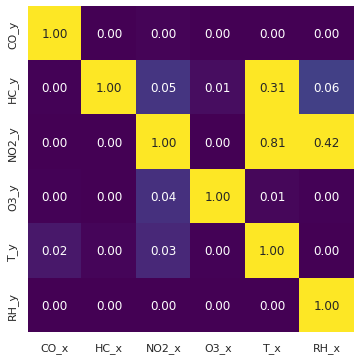

In [42]:
# plot g_test heatmap
display(g_test)
plt.figure(figsize=(8,6))
sns.heatmap(g_test, vmax=0.3, square=True, annot=True, fmt='.2f', cbar=False, cmap='viridis')

Observations:

* P-value of `T_x` < 0.05 for `CO` and `O3`. Thus we can Reject H0 and conclude Time series of `T` causes time series `CO` and `O3`
* P-value of `RH_x` < 0.05 for `CO` ,`HC` and `O3`. Thus we can Reject H0 and conclude Time series of `RH_x` causes time series `CO` ,`HC` and `O3`
* P-value of all gases < 0.05 for all other gases. Thus we can Reject H0 and conclude time series of any one gas causes time series of any other gas

Conclusion:

`T` and `RH` might be a good exogenous variable. 
Attempt to use SARIMAX instead of SARIMA and also attempt VARMAX


# SARIMAX

Since we know that all our gases time series has strong seasonality, from Seasonal Decomposition and ACF PACF plots and from Granger’s Causality Test potential exogenous factors `T` and `RH` that significantly causes other gases time series

### SARIMAX Data processing

Split into endo and exog variables

In [43]:
# Extract exogenous variables X and endogenous variable Y

SARIMAX_ts = df_pivot_impute.copy()
X_clean, y_clean = SARIMAX_ts[['T', 'RH']], SARIMAX_ts.drop(['T', 'RH'], axis=1)
print(X_clean.shape, y_clean.shape)


(328, 2) (328, 4)


In [44]:
X_clean_2 = X_clean.copy()
# Drop first row
X_clean_2 = X_clean_2.drop(X_clean_2.index[0])
X_clean_2.head()

Gas                 T         RH
Date                            
2016-03-16   9.833333  64.069791
2016-03-17  11.292708  51.107292
2016-03-18  12.866319  51.530903
2016-03-19  16.016667  48.843750
2016-03-20  17.370833  50.320833

## SARIMAX Modelling

we will use inital model order from ACF and PACF plot

  0%|          | 0/4 [00:00<?, ?it/s]

Exog gas found
Exog gas found
Exog gas found


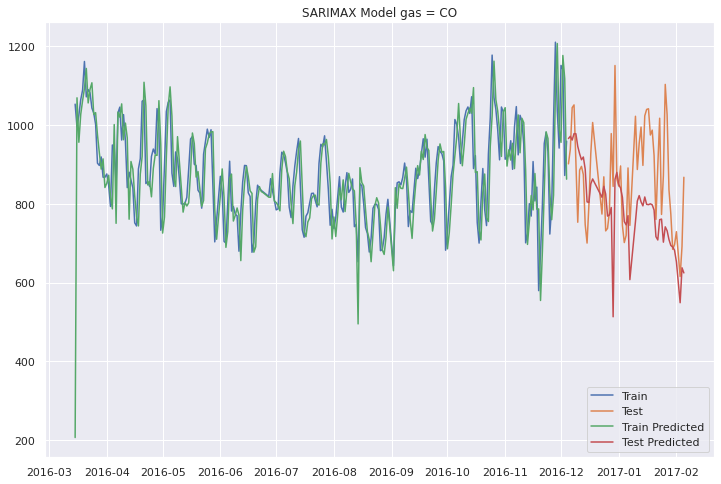

 25%|██▌       | 1/4 [00:00<00:02,  1.39it/s]

Exog gas found
Exog gas found
Exog gas found


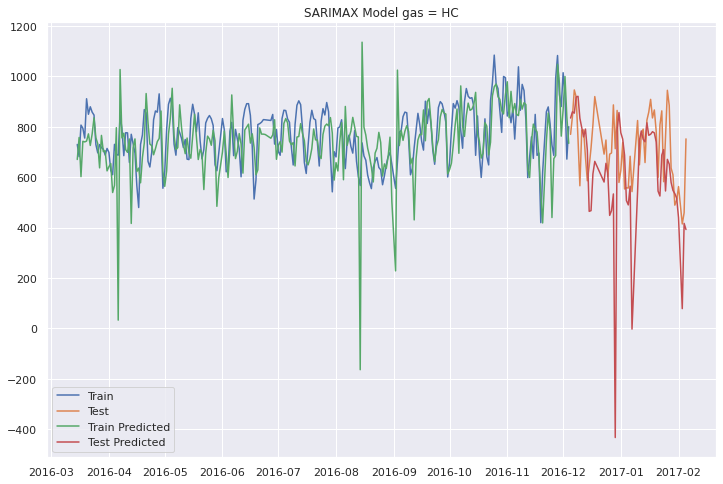

 50%|█████     | 2/4 [00:01<00:01,  1.37it/s]

Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Exog gas found
Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



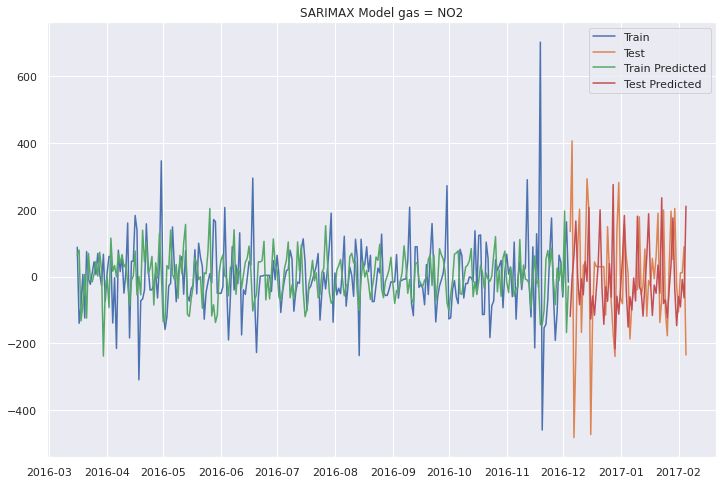

 75%|███████▌  | 3/4 [00:14<00:06,  6.50s/it]

Exog gas found
Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



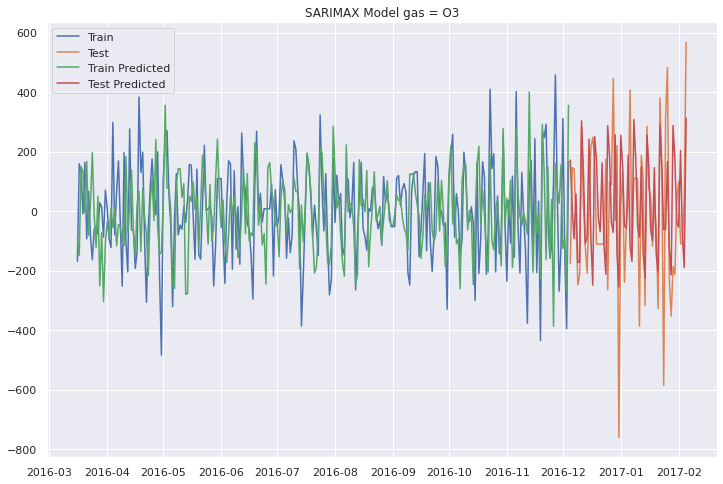

100%|██████████| 4/4 [00:18<00:00,  4.64s/it]


In [45]:
SARIMAX_Results = defaultdict(list)
target_feature = ['CO', 'HC', 'NO2', 'O3']
SARIMAX_models = []
# target_features = ['CO']


seasonal_orders = {
    "CO" : (1,0,0,7),
    "HC" :  (2,0,0,7),
    "NO2" :  (2,1,0,13),
    "O3" :  (1,1,0,7)
}
orders = {
    "CO" : (2,0,3),
    "HC" : (2,0,3),
    "NO2" : (2,1,1),
    "O3" : (2,1,1)
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(target_feature):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas]
        if gas in differenced_features:
            # Difference before fitting
            model, eval_results = modelEvaluation(SARIMAX, y_clean[gas].diff(periods=1).dropna(),gas=gas,exog =X_clean_2,target_features=target_feature,curve= True ,order = order, seasonal_order = seasonal_order)
        else:
            model, eval_results = modelEvaluation(SARIMAX, endog = y_clean[gas], gas = gas,exog =X_clean, target_features=target_features, curve = True,model_params = {'order' : order, 'seasonal_order' : seasonal_order })
        SARIMAX_Results[gas] = eval_results
        SARIMAX_models.append(model)
        Total_history = addHistory(f"SARIMAX-{order}-{gas}", eval_results, gas, past_history=Total_history)
    # display(VARMAX_Results)

results = parse_results(SARIMAX_Results)

In [46]:
results.T

0            1            2
CO  Train RMSE           101.663190    89.900388    90.402083
    Test RMSE            148.443503   211.780524   146.100320
    Difference in RMSE   -46.780313  -121.880136   -55.698237
    AIC                 1575.197292  2260.077923  3046.797344
HC  Train RMSE           111.391356    97.821099   126.184789
    Test RMSE            189.257110   267.771548   238.958393
    Difference in RMSE   -77.865754  -169.950449  -112.773604
    AIC                 1712.831369  2371.878806  3324.285642
NO2 Train RMSE           111.486127   105.735758   122.449444
    Test RMSE            104.701056   159.634643   196.949397
    Difference in RMSE     6.785071   -53.898886   -74.499953
    AIC                 1536.909886  2287.731058  3134.213909
O3  Train RMSE           159.091657   148.326286   161.691337
    Test RMSE            146.882838   221.538065   247.747201
    Difference in RMSE    12.208820   -73.211780   -86.055864
    AIC                 1697.063828  2484.269267  3341.228680

### Cross Validation Observations

* Compared to ARIMA, SARIMAX model overfits slightly more

                               SARIMAX Results                                
Dep. Variable:                     CO   No. Observations:                  265
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1519.399
Date:                Fri, 12 Aug 2022   AIC                           3046.797
Time:                        03:47:50   BIC                           3061.116
Sample:                    03-15-2016   HQIC                          3052.550
                         - 12-04-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              3.3085      0.879      3.764      0.000       1.586       5.031
RH             3.0432      0.527      5.777      0.000       2.011       4.076
ar.L1          0.9946      0.007    150.070      0.0

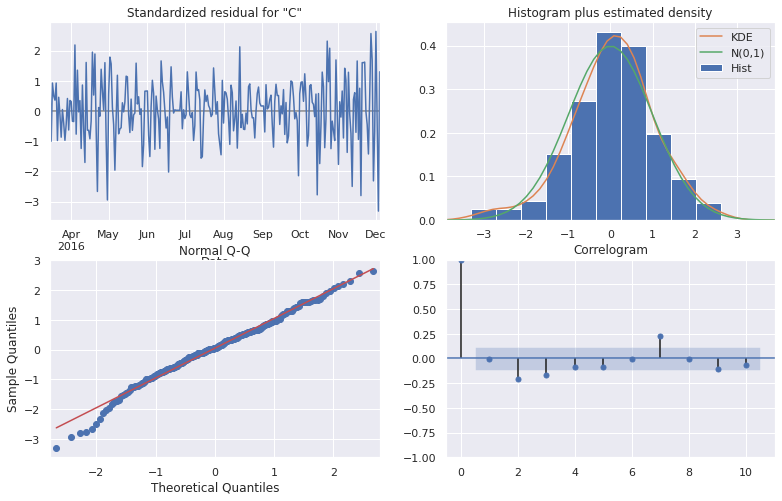

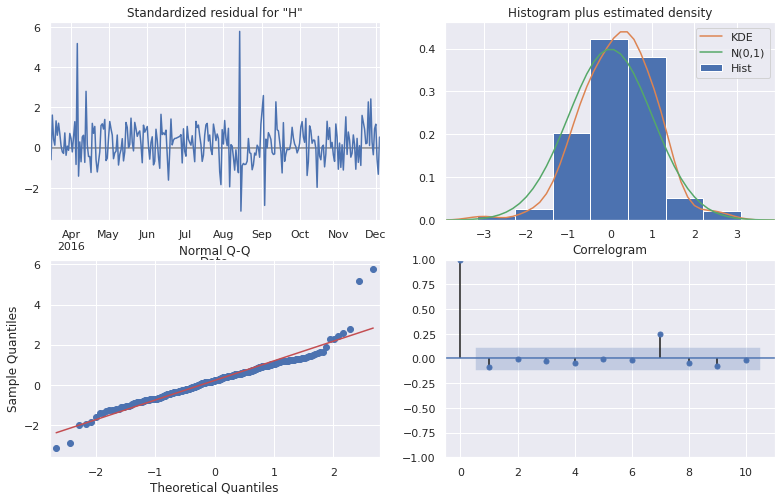

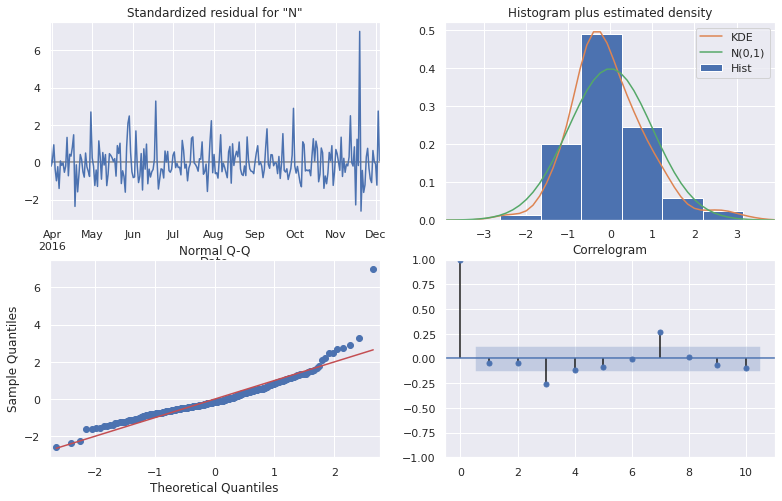

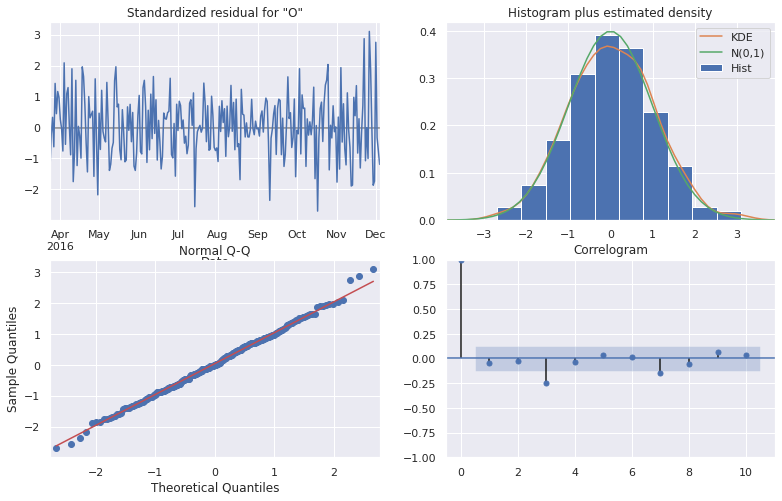

In [47]:
for model in SARIMAX_models:
    print(model.summary())
    print(model.plot_diagnostics())

#### **Individual Gases Observations ARIMA**

* CO
    * All coefficients are statistically significant
    * The errors caused are not white noise
    * The residuals show no variances
    * Data is normally distributed against an alternative of another distribution
* HC
    * All coefficients are statistically significant
    * Ther errors caused are white noise
    * The residuals show no variances
    * Data is normally distributed against an alternative of another distribution
* NO2
    * `T` and `RH` are not statistically significant as its P-value > 0.05 at 0.26 and 0.23 respectively
    * The errors caused are white noise
    * The residuals no show variances
    * Data is normally distributed against an alternative of another distribution
* O3
    * `T` and ar(1) are not statistically significant as its P-value > 0.05 at 0.95 and 0.26 respectively
    * The errors are white noise
    * The residuals show no variances
    * Data is normally distributed against an alternative of another distribution

#### General SARIMAX model conclusion

Generally, each model will need to be tuned further using their respective order and seasonal orders.
Based on side by side comparism of prediction visisualization, we can see that SARIMAX follows the trend to the actual forecast much better than ARIMA. There is still presence of spikes in correlogram at values of 7 for `CO`,`HC` and `NO2` and negative at value of 3 for `CO`,`NO2`and `O3`
Hence we will choose to hyperparam tune SARIMAX model 

In [48]:
Total_history.sort_values(by=['Gas','Mean Test RMSE'], ascending=True)

Model Name  Mean Test RMSE  Difference in RMSE  Gas
0     ARIMA-(2, 0, 3)-CO      123.908794          -56.098312   CO
4   SARIMAX-(2, 0, 3)-CO      168.774782          -74.786229   CO
1     ARIMA-(2, 0, 3)-HC      129.175004          -56.676773   HC
5   SARIMAX-(2, 0, 3)-HC      231.995684         -120.196602   HC
2    ARIMA-(2, 1, 2)-NO2      128.850184          -34.690101  NO2
6  SARIMAX-(2, 1, 1)-NO2      153.761699          -40.537922  NO2
3     ARIMA-(2, 1, 2)-O3      187.544850          -52.536574   O3
7   SARIMAX-(2, 1, 1)-O3      205.389368          -49.019608   O3

Comparing ARIMA vs SARIMAX

ARIMA model performed better then SARIMAX in all 4 gases however SARIMAX is able to 

## SARIMAX Hyperparamter tuning



SARIMAX requires not only the **p, d, and q** arguments that ARIMA requires but it also requires another set of **p, d, and q** arguments for the seasonality aspect as well as an argument called **s** which is the data’s seasonal cycle.

We will perform a exhausitive grid search to find all possible combinations of p’s, d’s, and q’s

In [73]:
# Extract exogenous variables X and endogenous variable Y

SARIMAX_ts = df_pivot_impute.copy()
X_clean, y_clean = SARIMAX_ts[['T', 'RH']], SARIMAX_ts.drop(['T', 'RH'], axis=1)
print(X_clean.shape, y_clean.shape)

X_clean_2 = X_clean.copy()
# Drop first row
X_clean_2 = X_clean_2.drop(X_clean_2.index[0])
X_clean_2.head()

(328, 2) (328, 4)


Gas                 T         RH
Date                            
2016-03-16   9.833333  64.069791
2016-03-17  11.292708  51.107292
2016-03-18  12.866319  51.530903
2016-03-19  16.016667  48.843750
2016-03-20  17.370833  50.320833

In [74]:
import itertools
# Grid Search all SARIMAX parameters


SARIMAX_hyperparamTuning_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Gas'])
target_feature = ['CO', 'HC', 'NO2', 'O3']

p  = q = range(0,7)
d= range(0,2)
pdq = list(itertools.product(p,d,q)) # all possible combinations of p,d,q

p2 = q2 = range(0, 7)
d2 = range(0, 2)
pdq2 = list(itertools.product(p2,d2,q2)) # all possible combinations of p2,d2,q2

s = 7 # seasonality

pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2] # all possible combinations of p,d,q,s

for combination in tqdm(pdq):
    for seasonal_combination in pdqs2:
        for gas in target_feature:
            if gas in differenced_features:
            # Difference before fitting
                model, eval_results = modelEvaluation(SARIMAX, y_clean[gas].diff(periods=1).dropna(),gas=gas,exog =X_clean_2,target_features=target_feature,curve= False ,model_params = {'order' : combination, 'seasonal_order' : seasonal_combination })
            else:
                model, eval_results = modelEvaluation(SARIMAX, endog = y_clean[gas], gas = gas,exog =X_clean, target_features=target_features, curve = False, model_params = {'order' : combination, 'seasonal_order' : seasonal_combination })
            SARIMAX_hyperparamTuning_history = addHistory(f"SARIMAX-{combination}-{seasonal_combination}-{gas}", eval_results, gas, past_history=SARIMAX_hyperparamTuning_history)


100%|██████████| 98/98 [1:52:59<00:00, 69.18s/it]


In [76]:
display(SARIMAX_hyperparamTuning_history[SARIMAX_hyperparamTuning_history['Gas'] == 'CO'].sort_values(by='Mean Test RMSE', ascending=True).head())
display(SARIMAX_hyperparamTuning_history[SARIMAX_hyperparamTuning_history['Gas'] == 'HC'].sort_values(by='Mean Test RMSE', ascending=True).head())
display(SARIMAX_hyperparamTuning_history[SARIMAX_hyperparamTuning_history['Gas'] == 'NO2'].sort_values(by='Mean Test RMSE', ascending=True).head())
display(SARIMAX_hyperparamTuning_history[SARIMAX_hyperparamTuning_history['Gas'] == 'O3'].sort_values(by='Mean Test RMSE', ascending=True).head())


Model Name  Mean Test RMSE  Difference in RMSE  \
0      SARIMAX-(0, 0, 0)-(0, 0, 0, 7)-CO      168.774782          -74.786229   
25596  SARIMAX-(4, 1, 2)-(2, 0, 1, 7)-CO      168.774782          -74.786229   
25600  SARIMAX-(4, 1, 2)-(2, 0, 2, 7)-CO      168.774782          -74.786229   
25604  SARIMAX-(4, 1, 2)-(2, 0, 3, 7)-CO      168.774782          -74.786229   
25608  SARIMAX-(4, 1, 2)-(2, 0, 4, 7)-CO      168.774782          -74.786229   

      Gas  
0      CO  
25596  CO  
25600  CO  
25604  CO  
25608  CO

Model Name  Mean Test RMSE  Difference in RMSE  \
1      SARIMAX-(0, 0, 0)-(0, 0, 0, 7)-HC      231.995684         -120.196602   
25597  SARIMAX-(4, 1, 2)-(2, 0, 1, 7)-HC      231.995684         -120.196602   
25601  SARIMAX-(4, 1, 2)-(2, 0, 2, 7)-HC      231.995684         -120.196602   
25605  SARIMAX-(4, 1, 2)-(2, 0, 3, 7)-HC      231.995684         -120.196602   
25609  SARIMAX-(4, 1, 2)-(2, 0, 4, 7)-HC      231.995684         -120.196602   

      Gas  
1      HC  
25597  HC  
25601  HC  
25605  HC  
25609  HC

Model Name  Mean Test RMSE  Difference in RMSE  \
2      SARIMAX-(0, 0, 0)-(0, 0, 0, 7)-NO2      128.382681          -31.831255   
25598  SARIMAX-(4, 1, 2)-(2, 0, 1, 7)-NO2      128.382681          -31.831255   
25602  SARIMAX-(4, 1, 2)-(2, 0, 2, 7)-NO2      128.382681          -31.831255   
25606  SARIMAX-(4, 1, 2)-(2, 0, 3, 7)-NO2      128.382681          -31.831255   
25610  SARIMAX-(4, 1, 2)-(2, 0, 4, 7)-NO2      128.382681          -31.831255   

       Gas  
2      NO2  
25598  NO2  
25602  NO2  
25606  NO2  
25610  NO2

Model Name  Mean Test RMSE  Difference in RMSE  \
3      SARIMAX-(0, 0, 0)-(0, 0, 0, 7)-O3      187.145583           -36.17177   
25599  SARIMAX-(4, 1, 2)-(2, 0, 1, 7)-O3      187.145583           -36.17177   
25603  SARIMAX-(4, 1, 2)-(2, 0, 2, 7)-O3      187.145583           -36.17177   
25607  SARIMAX-(4, 1, 2)-(2, 0, 3, 7)-O3      187.145583           -36.17177   
25611  SARIMAX-(4, 1, 2)-(2, 0, 4, 7)-O3      187.145583           -36.17177   

      Gas  
3      O3  
25599  O3  
25603  O3  
25607  O3  
25611  O3

# VARMAX 

The VARMAX best used on a multivariate time series, which is suitable for our current Gas prediction time series, being given exog endogenous variables Temperature and RH. 

The VARMAX procedure estimates the model parameters and generates forecasts associated with vector autoregressive moving-average processes with exogenous regressors

[References: SAS/ETS®
13.2 User’s Guide
The VARMAX Procedure](https://support.sas.com/documentation/onlinedoc/ets/132/varmax.pdf)

## VARMAX Data preprocessing

In [51]:
varmax_ts = df_pivot_impute.copy()
# spliting into exogenous (X) and endog (y) variables

X_clean, y_clean = varmax_ts[['T', 'RH']], varmax_ts.drop(['T', 'RH'], axis=1)
print(X_clean.shape, y_clean.shape)

(328, 2) (328, 4)


## VARMAX Modelling


In [52]:
# model = VARMAX(endog=y_clean, exog=X_clean, order=(1, 1)).fit(maxiter=1000, disp=False)

VARMAX_Results = defaultdict(list)
# target_features = ['CO', 'HC', 'NO2', 'O3']
# target_features = ['CO']
VARMAX_models = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    model, eval_results = modelEvaluation(VARMAX, endog = y_clean,gas='All',exog =X_clean,curve=False, target_features=target_features, order = (1,1))
    VARMAX_Results["All"] = eval_results
    VARMAX_models.append(model)
    Total_history = addHistory(f"VARMA-All-(1,0)", eval_results, "All", past_history=Total_history)
    # display(VARMAX_Results)

results = parse_results(VARMAX_Results)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning:

Exogenous array provided, but additional data is not required. `exog` argument ignored.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning:

Exogenous array provided, but additional data is not required. `exog` argument ignored.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



Exog gas found


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning:

Exogenous array provided, but additional data is not required. `exog` argument ignored.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



In [53]:
results.T

0            1             2
All Train RMSE            83.840677    81.712754     95.359912
    Test RMSE            114.433853   188.174518    188.316250
    Difference in RMSE   -30.593175  -106.461764    -92.956337
    AIC                 5931.050662  8593.307582  11478.419932

Cross Validation Observations ARIMA:

smt smt

                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  265
Model:                           VARMAX(1,1)   Log Likelihood               -5685.210
                                 + intercept   AIC                          11478.420
Date:                       Fri, 12 Aug 2022   BIC                          11671.725
Time:                               04:21:57   HQIC                         11556.087
Sample:                           03-15-2016                                         
                                - 12-04-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     4.58, 0.28, 0.01, 4.15   Jarque-Bera (JB):   11.59, 0.04, 1545.28, 63.95
Prob(Q):                0.03, 0.59, 0.94, 0.04   Prob(JB):                0.00, 0.98, 0.00, 0.00
Heteroskedasticity (H): 1.46, 1.

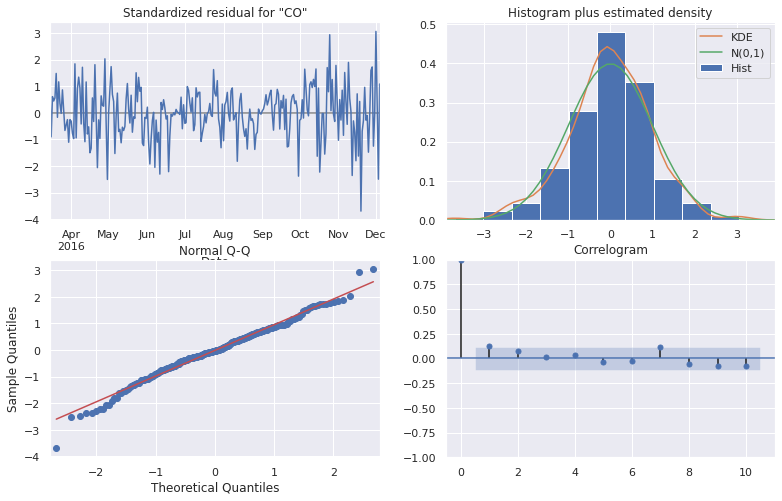

In [54]:
for model in VARMAX_models:
    print(model.summary())
    print(model.plot_diagnostics())

## Observations

* Only `NO2` errors caused are not white noise , `CO`,`HC` and `O3` errors caused are white noise
* All gases residuals show no variances
* Only `HC` data is not normally distributed against an alternative of another distribution

Histogram of residuals appear to be noramlly distributed
Lag 1 and 7 appears to be out of significance confidence interval which means model might require some tuning

## VARMAX Hyperparam tuning


In [ ]:
# Hyperparameter tune VARMAX model
varmax_tuning_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Gas'])
target_features = ['CO', 'HC', 'NO2', 'O3']
p = np.arange(1, 4, 1)
q = np.arange(1, 4, 1)

for p_val in p:
    for q_val in q:
        eval_results = modelEvaluation(VARMAX, endog = y_clean,exog =X_clean, target_features=target_features, order = (p_val,q_val),curve=False)
        varmax_tuning_history = addHistory(f"VARMA-{p_val}-{q_val}", eval_results, "All", past_history=varmax_tuning_history)
        # display(VARMAX_Results)


In [ ]:
varmax_tuning_history

Conclusion use order (1,1)

# TESTING Change datetime to weekly frequency

In [55]:
ts_weekly = df_pivot_impute.resample('W').mean()

In [56]:
plot_ts(ts_weekly,'Weekly')

## TESTING VARMAX ON weekly

In [57]:
varmax_ts_weekly = ts_weekly.copy()
X_clean, y_clean = varmax_ts_weekly[['T', 'RH']], varmax_ts_weekly.drop(['T', 'RH'], axis=1)
print(X_clean.shape, y_clean.shape)

(47, 2) (47, 4)


In [58]:
def modelEvaluation_weekly(model,endog,exog=None,tscv=TimeSeriesSplit(n_splits=3,test_size=9),curve=True,**kwargs):
  '''
  Function takes in a model, endog variable/exog variable(if any) splits into rolling average windows and evaluates the model on each window 
  Returns a dataframe with the model evaluation metrics
  Returns a time series plot of the model evaluation metrics on the last window only
  Returns model parameters
  '''
  results = defaultdict(list)
  for idx, (train_idx,test_idx) in enumerate(tscv.split(endog)): # Expanding Window 
    if exog is not None:
      train_exog = exog.iloc[train_idx]
      test_exog = exog.iloc[test_idx]
    else:
      train_exog =None
      test_exog = None

    train_fold = endog.iloc[train_idx]
    test_fold = endog.iloc[test_idx]

    # display(train_exog)
    # display(train_fold)
    if exog is not None:
      res = model(train_fold, exog.iloc[train_idx], **kwargs).fit()
      print('passed through exog')
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1],exog=train_exog)
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1],exog=test_exog)
      print('passed through exog2')
    else:
      res = model(train_fold,**kwargs).fit()
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1])
      # train_predict = res.forecast(len(train_idx))
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    # test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    rmse_train = mean_squared_error(train_fold, train_predict,squared=False) # Get train rmse for each split
    results['Train RMSE'].append(rmse_train)
    rmse_test = mean_squared_error(test_fold,test_predict,squared=False) # Get test rmse for each split
    results['Test RMSE'].append(rmse_test)
    results['Difference in RMSE'].append(rmse_train - rmse_test)
    results['AIC'].append(res.aic)

    if curve and idx == 2: # Only plot Time series for last fold 
      plt.figure(figsize=(12,8))
      plt.plot(train_fold,label='Train')
      plt.plot(test_fold,label='Test')
      plt.plot(train_predict,label='Train Predicted')
      plt.plot(test_predict,label='Test Predicted')
      plt.legend()
      plt.title(f'{model.__name__} Model ')
      plt.show()
  # results['Train RMSE'] = np.array(['Train RMSE']).mean()
  # display(results)
  return res , results

In [59]:
# Kaggle Competition 
## Load Prepare Test Dataset

# Load
df_test_raw = pd.read_csv('../Data/test.csv')
df_test_raw['Date'] = pd.to_datetime(df_test_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
# df_test_raw.set_index('Date', inplace=True) # Set Datatime as index

# df_test_raw_pivot = pd.pivot(df_test_raw, values="Value", columns="Gas")
# df_test_raw_pivot[["T", "RH"]] = df_test_raw[["T", "RH"]].groupby(df_test_raw.index).mean()
display(df_test_raw)
## Extreme outlier value handling
df_test_raw['Drift'] =  (df_test_raw['T'] < -49) | (df_test_raw['RH'] < 0) # Initialise a Drift Variable
g = sns.FacetGrid(
        pd.melt(df_test_raw, id_vars=['Date', 'Drift'], value_vars=['T','RH']).drop_duplicates(), 
        col="variable",
        hue='Drift',
        col_wrap= 2,
        sharey=False,
        height=3.5,
        aspect=1.5
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
g.add_legend()
plt.show()
# Front Fill all values 
df_test_raw.loc[df_test_raw[df_test_raw['Drift']].index,['T','RH']] = np.nan 
df_test_raw_imp = df_test_raw.fillna(method='ffill')
df_test_raw_imp[df_test_raw_imp['Drift']]
### Extract exogenous testing set
X_test = df_test_raw_imp.set_index("Date")[['T', 'RH']].resample('d').mean()
X_test.head(10)
## VARMAX forecast on Kaggle test set
final_train_endog = df_pivot_impute[target_feature]
final_train_exog = df_pivot_impute[['T','RH']]
Final_varmax = VARMAX(endog = final_train_endog,exog = final_train_exog, order=(1, 0)).fit()
predictions = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
predictions.plot()
plt.title('Predicted Gas Values')
predictions = pd.melt(predictions, value_vars=['CO', 'HC', 'NO2', 'O3'], value_name='Value')
predictions.index.rename('id', inplace=True)
predictions
## Padding -200 values
predictions.Value[predictions.index.isin([8,9,71,72,134,135,197,198])] = -160
predictions[predictions.Value == -160]
predictions['id'] = range(0, len(predictions))
predictions
predictions[['id','Value']].to_csv("/content/drive/MyDrive/Submissions/VARMAX1.csv",index=False)VARMAX_Results = defaultdict(list)
target_features = ['CO', 'HC', 'NO2', 'O3']
# target_features = ['CO']


with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    model, eval_results = modelEvaluation_weekly(VARMAX, endog = y_clean,exog =X_clean, curve=False,order = (1,0))
    VARMAX_Results[gas] = eval_results


    Total_history = addHistory(f"VARMA-All-(1,1)", eval_results, "All", past_history=Total_history)
    # display(VARMAX_Results)

results = parse_results(VARMAX_Results).describe()
results.T

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning:

Exogenous array provided, but additional data is not required. `exog` argument ignored.



passed through exog
passed through exog2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning:

Exogenous array provided, but additional data is not required. `exog` argument ignored.



passed through exog
passed through exog2
passed through exog
passed through exog2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning:

Exogenous array provided, but additional data is not required. `exog` argument ignored.



count         mean         std         min  \
O3 Train RMSE            3.0    60.743322    7.416901   54.521618   
   Test RMSE             3.0   126.947145   25.616441   99.570550   
   Difference in RMSE    3.0   -66.203824   23.549953  -91.578337   
   AIC                   3.0  1238.460455  388.823704  849.409920   

                               25%          50%          75%          max  
O3 Train RMSE            56.639454    58.757291    63.854174    68.951057  
   Test RMSE            115.252904   130.935257   140.635443   150.335628  
   Difference in RMSE   -76.781269   -61.984201   -53.516567   -45.048933  
   AIC                 1044.162216  1238.914512  1432.985722  1627.056931

eh no bad leh sadly no time implement convert T_T

# Kaggle Competition 

## Load Prepare Test Dataset


In [ ]:
# Load
df_test_raw = pd.read_csv('../Data/test.csv')
df_test_raw['Date'] = pd.to_datetime(df_test_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
# df_test_raw.set_index('Date', inplace=True) # Set Datatime as index

# df_test_raw_pivot = pd.pivot(df_test_raw, values="Value", columns="Gas")
# df_test_raw_pivot[["T", "RH"]] = df_test_raw[["T", "RH"]].groupby(df_test_raw.index).mean()
display(df_test_raw)

id       Date          T         RH Gas  Unnamed: 5  Unnamed: 6
0      0 2017-02-06   6.616667  51.734375  CO         NaN         NaN
1      1 2017-02-07   7.613194  43.930903  CO         NaN         NaN
2      2 2017-02-08   7.252083  50.966667  CO         NaN         NaN
3      3 2017-02-09   7.473611  50.166319  CO         NaN         NaN
4      4 2017-02-10   5.571875  46.604167  CO         NaN         NaN
..   ...        ...        ...        ...  ..         ...         ...
247  247 2017-04-05  17.554167  50.092708  O3         NaN         NaN
248  248 2017-04-06  15.919792  35.959722  O3         NaN         NaN
249  249 2017-04-07  15.489583  32.213542  O3         NaN         NaN
250  250 2017-04-08  18.381250  33.686458  O3         NaN         NaN
251  251 2017-04-09  16.966667  42.791667  O3         NaN         NaN

[252 rows x 7 columns]

## Extreme outlier value handling

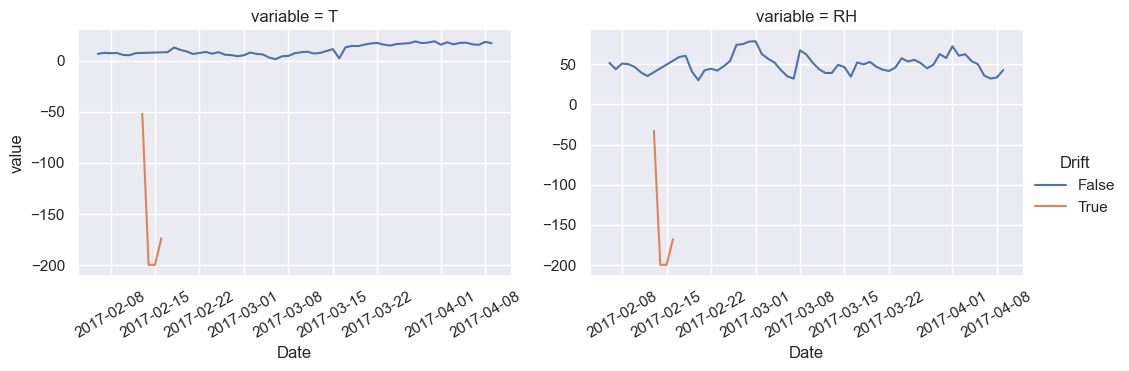

In [ ]:
df_test_raw['Drift'] =  (df_test_raw['T'] < -49) | (df_test_raw['RH'] < 0) # Initialise a Drift Variable
g = sns.FacetGrid(
        pd.melt(df_test_raw, id_vars=['Date', 'Drift'], value_vars=['T','RH']).drop_duplicates(), 
        col="variable",
        hue='Drift',
        col_wrap= 2,
        sharey=False,
        height=3.5,
        aspect=1.5
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
g.add_legend()
plt.show()

In [ ]:
# Front Fill all values 
df_test_raw.loc[df_test_raw[df_test_raw['Drift']].index,['T','RH']] = np.nan 
df_test_raw_imp = df_test_raw.fillna(method='ffill')
df_test_raw_imp[df_test_raw_imp['Drift']]

id       Date         T         RH  Gas  Unnamed: 5  Unnamed: 6  Drift
7      7 2017-02-13  7.307986  35.396875   CO         NaN         NaN   True
8      8 2017-02-14  7.307986  35.396875   CO         NaN         NaN   True
9      9 2017-02-15  7.307986  35.396875   CO         NaN         NaN   True
10    10 2017-02-16  7.307986  35.396875   CO         NaN         NaN   True
70    70 2017-02-13  7.307986  35.396875   HC         NaN         NaN   True
71    71 2017-02-14  7.307986  35.396875   HC         NaN         NaN   True
72    72 2017-02-15  7.307986  35.396875   HC         NaN         NaN   True
73    73 2017-02-16  7.307986  35.396875   HC         NaN         NaN   True
133  133 2017-02-13  7.307986  35.396875  NO2         NaN         NaN   True
134  134 2017-02-14  7.307986  35.396875  NO2         NaN         NaN   True
135  135 2017-02-15  7.307986  35.396875  NO2         NaN         NaN   True
136  136 2017-02-16  7.307986  35.396875  NO2         NaN         NaN   True
196  196 2017-02-13  7.307986  35.396875   O3         NaN         NaN   True
197  197 2017-02-14  7.307986  35.396875   O3         NaN         NaN   True
198  198 2017-02-15  7.307986  35.396875   O3         NaN         NaN   True
199  199 2017-02-16  7.307986  35.396875   O3         NaN         NaN   True

### Extract exogenous testing set

In [ ]:
X_test = df_test_raw_imp.set_index("Date")[['T', 'RH']].resample('d').mean()
X_test.head(10)

T         RH
Date                           
2017-02-06  6.616667  51.734375
2017-02-07  7.613194  43.930903
2017-02-08  7.252083  50.966667
2017-02-09  7.473611  50.166319
2017-02-10  5.571875  46.604167
2017-02-11  5.310417  39.594792
2017-02-12  7.307986  35.396875
2017-02-13  7.307986  35.396875
2017-02-14  7.307986  35.396875
2017-02-15  7.307986  35.396875

## VARMAX forecast on Kaggle test set

In [ ]:
final_train_endog = df_pivot_impute[target_feature]
final_train_exog = df_pivot_impute[['T','RH']]
Final_varmax = VARMAX(endog = final_train_endog,exog = final_train_exog, order=(1, 0)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


variable       Value
id                      
0         CO  979.961194
1         CO  918.212614
2         CO  942.345544
3         CO  939.083319
4         CO  914.573859
..       ...         ...
247       O3  824.549796
248       O3  769.521579
249       O3  781.177006
250       O3  812.290015
251       O3  841.696434

[252 rows x 2 columns]

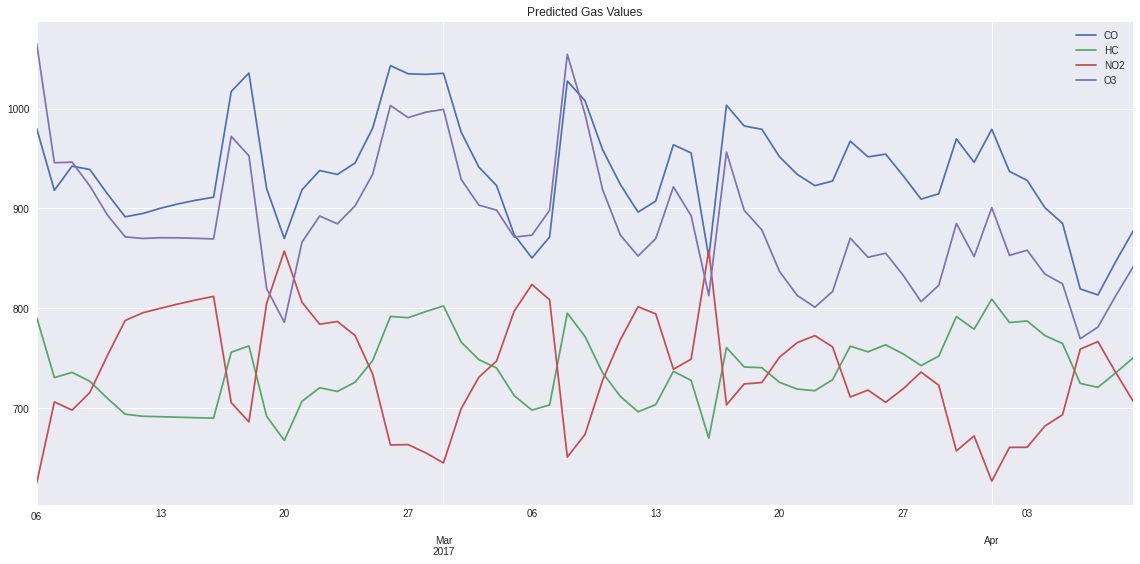

In [ ]:
predictions = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
predictions.plot()
plt.title('Predicted Gas Values')
predictions = pd.melt(predictions, value_vars=['CO', 'HC', 'NO2', 'O3'], value_name='Value')
predictions.index.rename('id', inplace=True)
predictions

## Padding -200 values

In [ ]:
predictions.Value[predictions.index.isin([8,9,71,72,134,135,197,198])] = -160
predictions[predictions.Value == -160]
predictions['id'] = range(0, len(predictions))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
predictions

variable       Value  error  index
id                                    
0         CO  979.961194  False      1
1         CO  918.212614  False      2
2         CO  942.345544  False      3
3         CO  939.083319  False      4
4         CO  914.573859  False      5
..       ...         ...    ...    ...
247       O3  824.549796  False    248
248       O3  769.521579  False    249
249       O3  781.177006  False    250
250       O3  812.290015  False    251
251       O3  841.696434  False    252

[252 rows x 4 columns]

In [ ]:
predictions[['id','Value']].to_csv("/content/drive/MyDrive/Submissions/VARMAX1.csv",index=False)